In [ ]:
!pip install einops
!pip install torchmetrics
!pip install livelossplot
!pip install pybedtools
!pip install Bio
!pip install Sophia-Optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 43.6 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.9.1-cp310-cp310-linux_x86_64.whl size=13997634 sha256=844b336c7f169f3daaad9cfe43b3212b5ed07036c3b2bc286a9760fc40d14f63
  Stored in directory: /root/.cache/pip/wheels/f5/79/76/c2cef660013cdf573214696aec4bc7ec352bf46141682230af
Successfully built pybedtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:

In [ ]:
# !nvidia-smi

In [ ]:
# CUDA_LAUNCH_BLOCKING="1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install memory_efficient_attention_pytorch

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.8 MB/s eta 0:00:00


# Import

In [ ]:
import os

os.getpid()
from functools import partial
from scipy.stats import zscore
import torch
import copy
import itertools
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from typing import List, Union
from torchmetrics.functional import kl_divergence
import random
import gc
from livelossplot import PlotLosses
from Bio import SeqIO
import pandas as pd
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from memory_efficient_attention_pytorch import Attention
from accelerate import Accelerator
from typing import List, Optional
%matplotlib inline

# Optimizer

https://github.com/kyegomez/Sophia

In [ ]:
class SophiaG(Optimizer):
    """
    SophiaG optimizer class.
    """
    def __init__(self, params, lr=5e-2, betas=(0.965, 0.99), rho = 0.04,
         weight_decay=1e-1, *, maximize: bool = False,
         capturable: bool = False, dynamic: bool = False):
        """
        Initialize the optimizer.
        """
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= rho:
            raise ValueError(f"Invalid rho parameter at index 1: {rho}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, betas=betas, rho=rho,
                        weight_decay=weight_decay,
                        maximize=maximize, capturable=capturable, dynamic=dynamic)
        super(SophiaG, self).__init__(params, defaults)

    def __setstate__(self, state):
        """
        Set the state of the optimizer.
        """
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('maximize', False)
            group.setdefault('capturable', False)
            group.setdefault('dynamic', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))

    @torch.no_grad()
    def update_hessian(self):
        """
        Update the hessian.
        """
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['hessian'].mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

    @torch.no_grad()
    def update_exp_avg(self):
        """
        Update the exponential average.
        """
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                state['exp_avg'].mul_(beta1).add_(p.grad, alpha=1 - beta1)

    @torch.no_grad()
    def step(self, closure=None, bs=5120):
        """
        Perform a step of the optimizer.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self.update_hessian()
        self.update_exp_avg()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            state_steps = []
            hessian = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)

                if p.grad.is_sparse:
                    raise RuntimeError('Hero does not support sparse gradients')
                grads.append(p.grad)
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avgs.append(state['exp_avg'])
                state_steps.append(state['step'])
                hessian.append(state['hessian'])

                if self.defaults['capturable']:
                    bs = torch.ones((1,), dtype=torch.float, device=p.device) * bs

            self._sophiag(params_with_grad,
                  grads,
                  exp_avgs,
                  hessian,
                  state_steps,
                  bs=bs,
                  beta1=beta1,
                  beta2=beta2,
                  rho=group['rho'],
                  lr=group['lr'],
                  weight_decay=group['weight_decay'],
                  maximize=group['maximize'],
                  capturable=group['capturable'])

        return loss

    def _sophiag(self, params: List[Tensor],
          grads: List[Tensor],
          exp_avgs: List[Tensor],
          hessian: List[Tensor],
          state_steps: List[Tensor],
          capturable: bool = False,
          *,
          bs: int,
          beta1: float,
          beta2: float,
          rho: float,
          lr: float,
          weight_decay: float,
          maximize: bool):
        """
        SophiaG function.
        """
        if not all(isinstance(t, torch.Tensor) for t in state_steps):
            raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

        self._single_tensor_sophiag(params,
             grads,
             exp_avgs,
             hessian,
             state_steps,
             bs=bs,
             beta1=beta1,
             beta2=beta2,
             rho=rho,
             lr=lr,
             weight_decay=weight_decay,
             maximize=maximize,
             capturable=capturable)

    def _single_tensor_sophiag(self, params: List[Tensor],
                         grads: List[Tensor],
                         exp_avgs: List[Tensor],
                         hessian: List[Tensor],
                         state_steps: List[Tensor],
                         *,
                         bs: int,
                         beta1: float,
                         beta2: float,
                         rho: float,
                         lr: float,
                         weight_decay: float,
                         maximize: bool,
                         capturable: bool):
        """
        SophiaG function for single tensor.
        """
        for i, param in enumerate(params):
            grad = grads[i] if not maximize else -grads[i]
            exp_avg = exp_avgs[i]
            hess = hessian[i]
            step_t = state_steps[i]

            if capturable:
                assert param.is_cuda and step_t.is_cuda and bs.is_cuda

            if torch.is_complex(param):
                grad = torch.view_as_real(grad)
                exp_avg = torch.view_as_real(exp_avg)
                hess = torch.view_as_real(hess)
                param = torch.view_as_real(param)

            # update step
            step_t += 1

            # Perform stepweight decay
            param.mul_(1 - lr * weight_decay)

            # Decay the first and second moment running average coefficient
            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

            if capturable:
                step = step_t
                step_size = lr
                step_size_neg = step_size.neg()

                ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
                param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)
            else:
                step = step_t.item()
                step_size_neg = - lr

                ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
                param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)

#Params

https://github.com/pinellolab/DNA-Diffusion

In [ ]:
GLOBAL_SEED = 42
NUCLEOTIDES = ['A', 'C', 'T', 'G']
types = ["Z-DNA", "G-quad", "H-DNA"]
N_SAMPLES = 1000
EPOCHS = 10000
SEQ_SIZE = 50
CHANNELS = 1
LEARNING_RATE = 1e-5
TIMESTEPS = 100
RESNET_BLOCK_GROUPS = 4
BATCH_SIZE = 16
TOTAL_CLASS_NUMBER = 2
gradient_accumulation_steps = 8

In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

#Functions

In [ ]:
def seed_everything(seed=GLOBAL_SEED):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def one_hot_encode(seq, nucleotides, max_seq_len):
    """
    One-hot encode a sequence of nucleotides.
    """
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(nucleotides)))
    for i in range(seq_len):
        seq_array[i, nucleotides.index(seq[i])] = 1
    return seq_array

In [ ]:
def log(t, eps=1e-20):
    """
    Toch log for the purporses of diffusion time steps t.
    """
    return torch.log(t.clamp(min=eps))

In [ ]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [ ]:
def exists(x):
    return x is not None

In [ ]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

In [ ]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [ ]:
def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

In [ ]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [ ]:
def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

In [ ]:
def l2norm(t):
    return F.normalize(t, dim=-1)

In [ ]:
def sampling_reverse_encoding(number_of_samples, specific_group=False, group_number=None, cond_weight_to_metric=0):
    """
    Stands for reverse encoding
    """
    final_sequences = []
    for n_a in tqdm(range(number_of_samples)):  # Use tqdm instead of tqdm_notebook
        sample_bs = 16
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample(
            model,
            classes=random_classes,
            image_size=100,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 100), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_seqs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()

In [ ]:
def KL_divergence(real: pd.Series, generated: pd.Series) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the KL divergence metric
    between two sequences.
    Returns
    -------
    kl_divergence: Float
      The KL divergence between the input and output (generated)
      sequences' distribution
    """

    kl_pq = rel_entr(real, generated)
    return np.sum(kl_pq)

In [ ]:
def one_hot_encoding(sequence, target_length):
    """Convert DNA sequence to one-hot encoding."""
    nucleotides = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_seq = np.zeros((target_length, len(nucleotides)))

    for i, nucleotide in enumerate(sequence[:target_length]):
        if nucleotide in nucleotides:
            one_hot_seq[i, nucleotides[nucleotide]] = 1

    # Flatten the one-hot encoding to a 1D vector
    one_hot_flat = one_hot_seq.flatten()

    return one_hot_flat

def preprocess_sequences(sequences, target_length):
    """Pad or truncate sequences to the target length."""
    return [seq.ljust(target_length, 'N')[:target_length] for seq in sequences]

def calculate_diversity_optimized_one_hot(dataset, target_length):
    """Calculate diversity within a single dataset using KDTree and one-hot encoding."""
    diversity = 0.0
    total_pairs = 0

    sequences = preprocess_sequences(dataset, target_length)

    sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in sequences]

    kdtree = KDTree(sequences_one_hot)

    for i, seq_i in enumerate(sequences_one_hot):
        for j, seq_j in enumerate(sequences_one_hot):
            if i != j:

                edit_dist_ij = editdistance.eval(seq_i, seq_j)
                diversity += edit_dist_ij
                total_pairs += 1

    if total_pairs > 0:
        diversity /= total_pairs

    return diversity

In [ ]:
zdef calculate_novelty_optimized_one_hot(generated_sequences, initial_sequences, target_length):
    """Calculate novelty of the generated sequences using KDTree and one-hot encoding."""
    novelty = 0.0
    total_pairs = 0

    initial_sequences = preprocess_sequences(initial_sequences, target_length)
    generated_sequences = preprocess_sequences(generated_sequences, target_length)

    initial_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in initial_sequences]
    generated_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in generated_sequences]

    kdtree = KDTree(initial_sequences_one_hot)

    for gen_seq_one_hot in generated_sequences_one_hot:

        distance, _ = kdtree.query(gen_seq_one_hot)
        novelty += distance
        total_pairs += 1

    if total_pairs > 0:
        novelty /= total_pairs

    return novelty

In [ ]:
def diversity(
    generated, real, scoring_metric=KL_divergence
):
    """
    This function encapsulates the logic of evaluating the difference between the distribution
    of frequencies between generated (diffusion/df_motifs_a) and the input (training/df_motifs_b) for an arbitrary metric ("motif_scoring_metric")

    Please note that some metrics, like KL_divergence, are not metrics in official sense. Reason
    for that is that they dont satisfy certain properties, such as in KL case, the simmetry property.
    Hence it makes a big difference what are the positions of input.
    """
    set_all_data = set(generated.index.values.tolist() + real.index.values.tolist())
    create_new_matrix = []
    for x in set_all_data:
        list_in = []
        list_in.append(x)  # adding the name
        if x in generated.index:
            list_in.append(generated.loc[x][0])
        else:
            list_in.append(1)

        if x in real.index:
            list_in.append(real.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_kl = pd.DataFrame(create_new_matrix, columns=['Flipon', 'generated', 'real'])

    df_kl['Generated_seqs'] = df_kl['generated'] / df_kl['generated'].sum()
    df_kl['Training_seqs'] = df_kl['real'] / df_kl['real'].sum()
    plt.rcParams["figure.figsize"] = (3, 3)
    sns.regplot(x='Generated_seqs', y='Training_seqs', data=df_kl)
    plt.xlabel('Generated_seqs')
    plt.ylabel('Training Seqs')
    plt.title('Motifs Probs')
    plt.show()

    return scoring_metric(df_kl['Genereated_seqs'].values, df_kl['Training_seqs'].values)

# Data import and preparation

In [ ]:
class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

In [ ]:
seed_everything()

#from dataprep

In [ ]:
!mkdir numpy_arrays_data

In [ ]:
class DataPrep:
    """
    This class encapsulates the preprocessing of raw bed files and fasta files. Raw bed files contain of initial positions of
    experimentaly detected secondary structures: Z-DNA, H-DNA, G-quads. Raw fasta files contain sequences with respect to
    positions. Columns ['chrom', 'chromStart', 'chromEnd'] illustrate the positions.
    Then raw fasta files are aligned to the same length and new bed files are generated and saved the positions.
    New fasta files are encoded and saved as numpy arrays.

    """
    def __init__(self, bed_file, fasta_file):
        self.bed_file = bed_file
        self.fasta_file = fasta_file

    def process_file(self, bed_file, fasta_file):

        pos_df = pd.read_csv(f'{bed_file}.bed', sep='\t', comment='t', header=None)
        header = ['chrom', 'chromStart', 'chromEnd']
        pos_df.columns = header[:len(pos_df.columns)]
        pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
        pos_df.head()
        plt.figure(figsize=(16,8))
        plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
        pos_df.len.quantile(0.5)
        pos_df.len[pos_df.len > 512].count()
        pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
        quad_len = 512
        pos_df_filter = pos_df[pos_df.len
        <= quad_len].copy().reset_index(drop=True)
        pos_df_filter.len.max()
        pos_df_filter['add_len'] = quad_len - pos_df_filter.len
        pos_df_filter['left_add_len'] = (pos_df_filter.add_len
        / 2).astype('int64')
        pos_df_filter['right_add_len'] = pos_df_filter.add_len \
        - pos_df_filter.left_add_len
        pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
        - pos_df_filter.left_add_len.astype('int64')
        pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
        + pos_df_filter.right_add_len.astype('int64')
        pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
        - pos_df_filter.new_chromStart.astype('int64')


        # Save initial positions
        pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd']].to_csv(
            f'{bed_file}_filter_norm_to_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter[['chrom', 'chromStart', 'chromEnd']].to_csv(
            f'{bed_file}_filter_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter.to_csv(f'{bed_file}_positions.csv')

        # Process sequences and save as numpy array
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    one_hot = []
                    for s in line.upper():
                        if s != '\n':
                            one_hot.append(codes[s])
                    one_hot_quads.append(one_hot)
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

        # Normalisation + labeling (example)
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    left = pos_df_filter.iloc[line_num].left_add_len
                    right = left + pos_df_filter.iloc[line_num].len
                    one_hot = []
                    for (i, s) in enumerate(line.upper()):
                        pos = 0.
                        if left <= i and i < right:
                            pos = 1.
                        if s != '\n':
                            one_hot.append(codes[s] + [pos])
                    one_hot_quads.append(np.array(one_hot))
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

    def process_all_files(self):
        for file1, file2 in zip(self.bed_file, self.fasta_file):
            self.process_file(file1, file2)

In [ ]:
beds_to_process = ['/content/drive/My Drive/DeepZ_data_creation/data/hg19_zdna/raw/WuKou16',
                   '/content/drive/My Drive/DeepZ_data_creation/data/hg19_zdna/raw/zdna2016',
                    '/content/drive/My Drive/data_for_gans/GSE107690_K562_High_confidence_peaks'
                    ]
fastas_to_process = ['/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016',
                     '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016'
                    ]

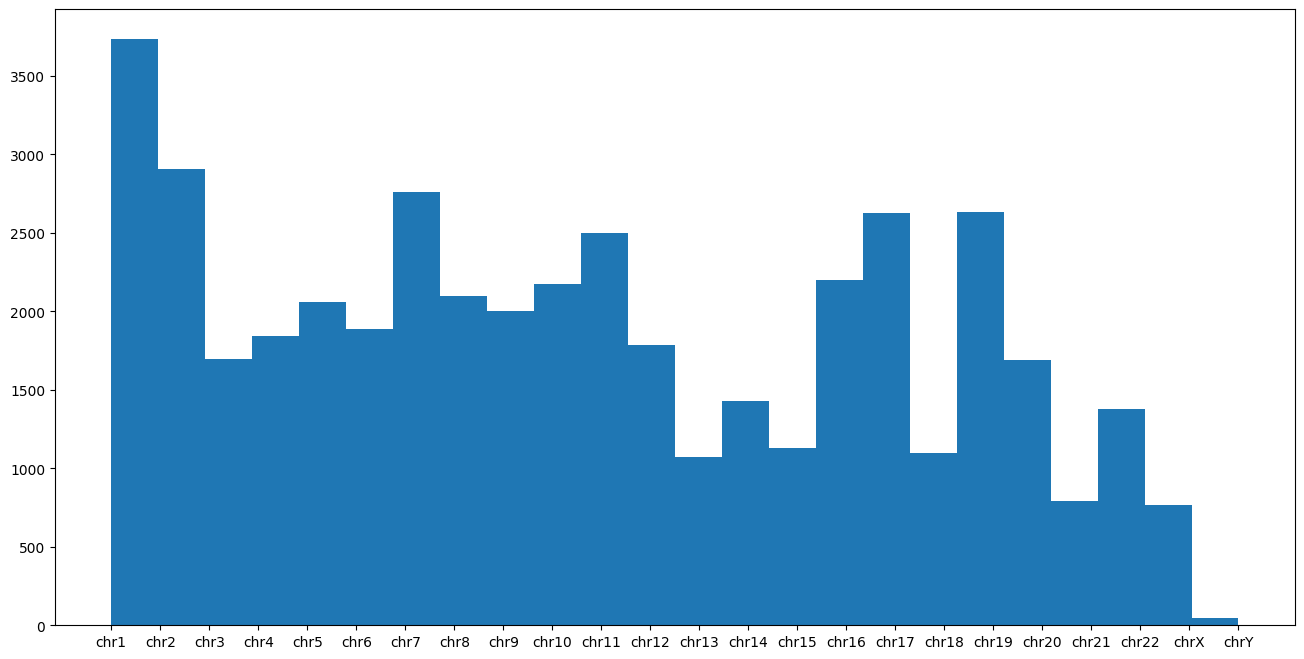

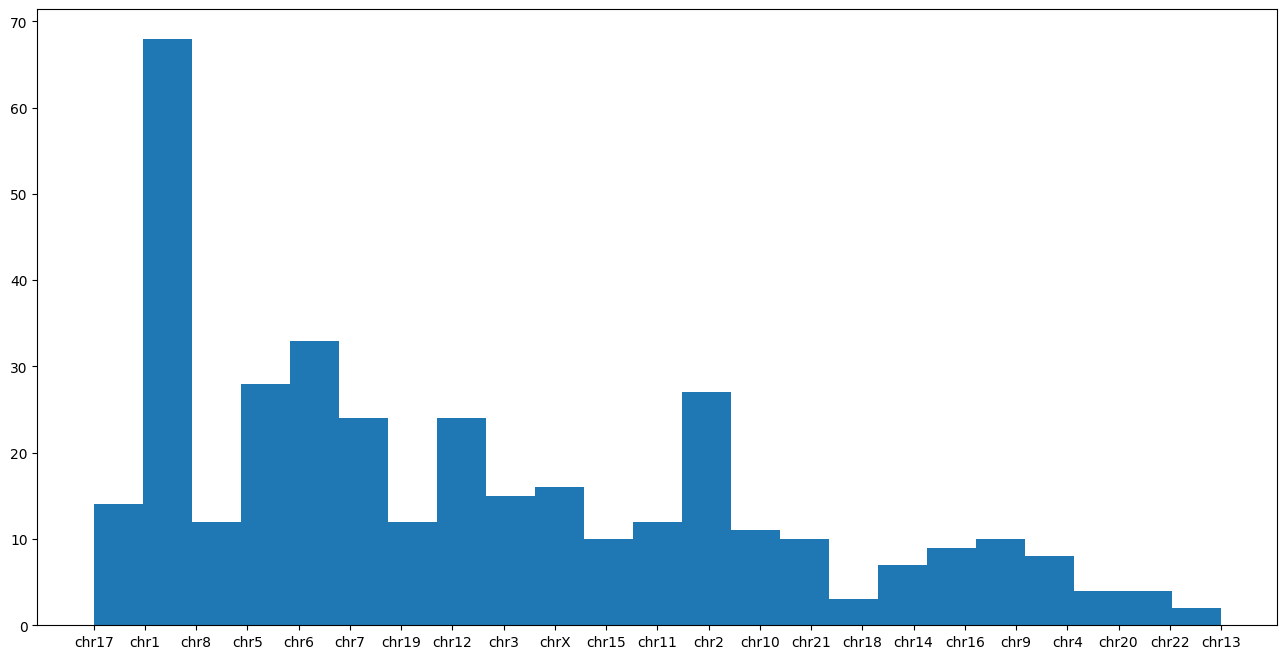

In [ ]:
data_preprocessor = DataPrep(beds_to_process, fastas_to_process)
data_preprocessor.process_all_files()

In [ ]:
bedWK_df = pd.read_csv('/content/drive/My Drive/DeepZ_data_creation/data/hg19_zdna/raw/WuKou16_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bed16_df = pd.read_csv('/content/drive/My Drive/DeepZ_data_creation/data/hg19_zdna/raw/zdna2016_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bedG_df = pd.read_csv('/content/drive/My Drive/data_for_gans/G4_Chip_seq_filter_norm_to_500.bed', sep='\t', comment='t', header=None)
bedH_df = pd.read_csv('/content/drive/My Drive/data_for_gans/H-DNA.bed', sep='\t', comment='t', header=None)

In [ ]:
un_bed_dataset = pd.concat([bedWK_df, bed16_df]).reset_index(drop=True)
un_bed_dataset = pd.concat([un_bed_dataset, bedG_df]).reset_index(drop=True)
un_bed_dataset = pd.concat([un_bed_dataset, bedH_df]).reset_index(drop=True)

In [ ]:
un_bed_dataset

0         1         2
0       chr1    845296    845808
1       chr1    845379    845891
2       chr1    845802    846314
3       chr1    845896    846408
4       chr1    848188    848700
...      ...       ...       ...
758210  chrY  59327304  59327324
758211  chrY  59329449  59329467
758212  chrY  59347150  59347170
758213  chrY  59348532  59348554
758214  chrY  59348997  59349025

[758215 rows x 3 columns]

In [ ]:
un_bed_dataset[:43936]

0          1          2
0      chr1     845296     845808
1      chr1     845379     845891
2      chr1     845802     846314
3      chr1     845896     846408
4      chr1     848188     848700
...     ...        ...        ...
43931  chrX  153166892  153167404
43932  chrY     234047     234559
43933  chrY     234181     234693
43934  chrY     234300     234812
43935  chrY     234415     234927

[43936 rows x 3 columns]

In [ ]:
un_bed_dataset.columns = ['chrom', 'chromStart', 'chromEnd']

In [ ]:
# fasta_file_path = '/content/generated_sequences_zdna_gans.fasta'
# with open(fasta_file_path, 'r') as fasta_file:
#     fasta_lines = fasta_file.readlines()

# for i, line in enumerate(fasta_lines):
#     if line.startswith('> seq'):
#         chrom_index = i % len(un_bed_dataset[:43936].chrom)
#         chromosome_name = un_bed_dataset.chrom[chrom_index]
#         fasta_lines[i] = f'> {chromosome_name}\n'

# updated_fasta_file_path = 'updated_sequences.fasta'
# with open(updated_fasta_file_path, 'w') as updated_fasta_file:
#     updated_fasta_file.writelines(fasta_lines)

# CL

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta',
    '/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[0])
raw_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
raw_dataset.head()

chromosome                                       raw_sequence  \
0  chr1:845296-845808  GCTATCTTCCAGGCCGGGAGGAAGGACCGAGGGTGGGCCCGGCGCG...   
1  chr1:845379-845891  CTGGTCCTGGCGCTGGGACCCGCAGCTGCGCCCTCTGCCTGAGCAG...   
2  chr1:845802-846314  CAGTCACCGGGGGCGGGGAGACTGGTCGACCACCCCTGAGGGCCCG...   
3  chr1:845896-846408  TCCTGGTTGAGCAGCTAGGGGGGTGTCTGGTAACCAGCCGGGCCCC...   
4  chr1:848188-848700  GCACTCCACAGCAGGAAGAAGGGCAGTGTGAACTGCTCACCACTGT...   

    type  label  
0  Z-DNA      0  
1  Z-DNA      0  
2  Z-DNA      0  
3  Z-DNA      0  
4  Z-DNA      0

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/drive/My Drive/data_for_gans/G4_Chip_seq_quadruplex_norm_to_500.fa'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[1])
g_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
g_dataset.head()

chromosome                                       raw_sequence  \
0  chr1:713888-714400  CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...   
1  chr1:762660-763172  GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...   
2  chr1:839885-840397  CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...   
3  chr1:894460-894972  CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...   
4  chr1:935301-935813  GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...   

     type  label  
0  G-quad      0  
1  G-quad      0  
2  G-quad      0  
3  G-quad      0  
4  G-quad      0

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    "/content/drive/My Drive/data_for_gans/preprocessed_fastas/HDNA_filter-norm_to_500.fasta"
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[2])
h_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 1})
h_dataset.head()

chromosome                                       raw_sequence   type  \
0  chr1:30624-31136  GCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGGTA...  H-DNA   
1  chr1:30686-31198  CCACTCATGTTGTAGACAGAATGTTTATGTCCTCTCCAAATGCTTA...  H-DNA   
2  chr1:31470-31982  ACTTTGGTAGGCTGACGCGAGAGGACTGCTTGAGCCCAAGAGTTTG...  H-DNA   
3  chr1:33275-33787  AAGGGGAGGGGAGAATGGGAAGTGGCTGCTTCATGGGTACAAGGTT...  H-DNA   
4  chr1:40392-40904  CACGCTGGCCCTCTGCTGTTCTTCGAAGCCACCAGGGCTGCATTGG...  H-DNA   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

In [ ]:
print(raw_dataset.shape)
print(g_dataset.shape)
print(h_dataset.shape)

(44661, 4)
(8723, 4)
(704830, 4)


In [ ]:
raw_dataset = pd.concat([raw_dataset, g_dataset]).sample(frac=1).reset_index(drop=True)

In [ ]:
raw_dataset = pd.concat([raw_dataset, h_dataset]).sample(frac=1).reset_index(drop=True)

In [ ]:
raw_dataset = g_dataset

In [ ]:
raw_dataset.shape

(8723, 4)

In [ ]:
val_chromosomes = ['chr3', 'chr8', 'chr15', 'chr17', 'chr20', 'chrX']

raw_dataset['short_chrom'] = raw_dataset['chromosome'].apply(lambda x: x.split(':')[0])

val_set = raw_dataset[raw_dataset['short_chrom'].isin(val_chromosomes)]
train_set = raw_dataset[~raw_dataset['short_chrom'].isin(val_chromosomes)]

val_set = val_set.drop(columns=['short_chrom'])
train_set = train_set.drop(columns=['short_chrom'])

In [ ]:
raw_dataset.to_csv("/content/drive/My Drive/New_Full_data.csv", index=False)

In [ ]:
raw_dataset.raw_sequence

0       CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...
1       GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...
2       CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...
3       CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...
4       GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...
                              ...                        
8718    TTGCGGAGACTGCAAGCAGCCGCGGCGCGCCCGGCCCTCCCTCTTC...
8719    CGCACGGGTCTCCTTAGCGGGCGGGCAAAATGGGCGCCGGTACTCG...
8720    CAGACTGCGACGGCTCAAGGTTCCCACACGCAGAATTTTCCTGGTA...
8721    TGGTGTCAGCATTTGTCCCTCCCACCCCCATGGACGGCACCACCTC...
8722    GAGCTTTTGTGAGCCAGGGAGCGAGGGCCGTCCCCGTGCTCCAGCC...
Name: raw_sequence, Length: 8723, dtype: object

In [ ]:
raw_dataset.type

0       G-quad
1       G-quad
2       G-quad
3       G-quad
4       G-quad
         ...  
8718    G-quad
8719    G-quad
8720    G-quad
8721    G-quad
8722    G-quad
Name: type, Length: 8723, dtype: object

# DF

In [ ]:
raw_dataset = pd.read_csv("/content/drive/My Drive/Zdna.csv")

In [ ]:
raw_dataset.head()

chromosome                                       raw_sequence  \
0  chr1:713888-714400  CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...   
1  chr1:762660-763172  GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...   
2  chr1:839885-840397  CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...   
3  chr1:894460-894972  CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...   
4  chr1:935301-935813  GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...   

     type  label short_chrom  
0  G-quad      0        chr1  
1  G-quad      0        chr1  
2  G-quad      0        chr1  
3  G-quad      0        chr1  
4  G-quad      0        chr1

Scale data from $[0;1]$ to $[-1, 1] → $BitDiffusion

In [ ]:
X_train = np.array(
    [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(train_set.raw_sequence) if 'N' not in x]
)
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
X_val = np.array(
    [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(val_set.raw_sequence) if 'N' not in x]
)
X_val = np.array([x.T.tolist() for x in X_val])
X_val[X_val == 0] = -1

<ipython-input-54-2457d02acc97>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(train_set.raw_sequence) if 'N' not in x]


  0%|          | 0/6797 [00:00<?, ?it/s]

<ipython-input-54-2457d02acc97>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(val_set.raw_sequence) if 'N' not in x]


  0%|          | 0/1926 [00:00<?, ?it/s]

In [ ]:
# def preprocess_sequences(data, max_length, nucleotides):
#     processed_data = []
#     for x in data:
#         if 'N' not in x:
#             processed_data.append(one_hot_encode(x, nucleotides, max_length))
#     processed_data = np.array([x.T.tolist() for x in processed_data])
#     processed_data[processed_data == 0] = -1
#     return processed_data

# def generate_batches(data, batch_size):
#     for i in range(0, len(data), batch_size):
#         yield data[i:i+batch_size]

In [ ]:
# batch_size = 1000
# max_length = 512

In [ ]:
# X_train = np.concatenate([
#     preprocess_sequences(batch, max_length, NUCLEOTIDES)
#     for batch in generate_batches(train_set.raw_sequence, batch_size)
# ])


In [ ]:
# X_val = np.concatenate([
#     preprocess_sequences(batch, max_length, NUCLEOTIDES)
#     for batch in generate_batches(val_set.raw_sequence, batch_size)
# ])

In [ ]:
y_X_train = torch.from_numpy(train_set["label"].to_numpy())
y_X_val = torch.from_numpy(val_set["label"].to_numpy())

In [ ]:
tf = T.Compose([T.ToTensor()])
seq_dataset_train = SequenceDataset(seqs=X_train, c=y_X_train, transform=tf)
train_dl = DataLoader(seq_dataset_train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
seq_dataset_val = SequenceDataset(seqs=X_val, c=y_X_val, transform=tf)
val_dl = DataLoader(seq_dataset_val, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# Forward Diffusion

In [ ]:
# Scheduler


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTEPS, beta_end=0.2)
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# Conditioned (improved) sampling


@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, time=t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Sampling based on Denoising Diffusion Implicit Models (https://arxiv.org/abs/2010.02502)

@torch.no_grad()
def p_ddpm_sample(model, x, t, t_index, eta=0, temp=1.0):
    alpha_t = extract(alphas_cumprod, t, x.shape)
    alpha_prev_t = extract(alphas_cumprod_prev, t, x.shape)
    sigma = eta * ((1 - alpha_prev_t) / (1 - alpha_t) * (1 - alpha_t / alpha_prev_t)) ** 0.5
    sqrt_one_minus_alphas_cumprod = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    pred_x0 = (x - sqrt_one_minus_alphas_cumprod * model(x, time=t)) / (alpha_t**0.5)
    dir_xt = (1.0 - alpha_prev_t - sigma**2).sqrt() * model(x, time=t)
    if sigma == 0.0:
        noise = 0.0
    else:
        noise = torch.randn((1, x.shape[1:]))
    noise *= temp

    x_prev = (alpha_prev_t**0.5) * pred_x0 + dir_xt + sigma * noise

    return x_prev


@torch.no_grad()
def p_ddim_sample(model, x, t, t_index, eta=0, temp=1.0):
    alpha_t = extract(alphas_cumprod, t, x.shape)
    alpha_prev_t = extract(alphas_cumprod_prev, t, x.shape)
    sigma = eta * ((1 - alpha_prev_t) / (1 - alpha_t) * (1 - alpha_t / alpha_prev_t)) ** 0.5
    sqrt_one_minus_alphas_cumprod = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    pred_x0 = (x - sqrt_one_minus_alphas_cumprod * model(x, time=t)) / (alpha_t**0.5)
    dir_xt = (1.0 - alpha_prev_t - sigma**2).sqrt() * model(x, time=t)
    if sigma == 0.0:
        noise = 0.0
    else:
        noise = torch.randn((1, x.shape[1:]))
    noise *= temp

    x_prev = (alpha_prev_t**0.5) * pred_x0 + dir_xt + sigma * noise

    return x_prev


@torch.no_grad()
def p_sample_guided(model, x, classes, t, t_index, context_mask, cond_weight=0.0):
    # adapted from: https://openreview.net/pdf?id=qw8AKxfYbI
    # print (classes[0])
    batch_size = x.shape[0]
    # double to do guidance with
    t_double = t.repeat(2)
    x_double = x.repeat(2, 1, 1, 1)
    betas_t = extract(betas, t_double, x_double.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t_double, x_double.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t_double, x_double.shape)

    # classifier free sampling interpolates between guided and non guided using `cond_weight`
    classes_masked = classes * context_mask
    classes_masked = classes_masked.type(torch.long)
    # print ('class masked', classes_masked)
    preds = model(x_double, time=t_double, classes=classes_masked)
    eps1 = (1 + cond_weight) * preds[:batch_size]
    eps2 = cond_weight * preds[batch_size:]
    x_t = eps1 - eps2

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t[:batch_size] * (
        x - betas_t[:batch_size] * x_t / sqrt_one_minus_alphas_cumprod_t[:batch_size]
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_weight):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        # make 0 index unconditional
        # double the batch
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0  # makes second half of batch context free
        sampling_fn = partial(p_sample_guided, classes=classes, cond_weight=cond_weight, context_mask=context_mask)
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='sampling loop time step', total=TIMESTEPS):
        img = sampling_fn(model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0):
    return p_sample_loop(model, classes=classes, shape=(batch_size, channels, 4, image_size), cond_weight=cond_weight)

### Loss function

In [ ]:
def q_sample(x_start, t, noise=None):
    """
    Forward pass with noise.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1", p_uncond=0.1):
    """
    Calculate the loss conditioned and noise injected.
    """
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = denoise_model(x_noisy, t, classes)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
def p_losses_dist(teacher_model, student_model, x_start, t, classes, noise=None, loss_type="huber", p_uncond=0.1, alpha=1e-2):
    """
    Calculate the loss conditioned and noise injected.
    """
    teacher_model.eval()
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
        context_mask_t = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)
        classes_t = classes * context_mask_t
        classes_t = classes_t.type(torch.long)
        teacher_noise = teacher_model(x_start, t, classes_t)
    x_noisy = q_sample(x_start=x_start, t=t, noise=teacher_noise)  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = student_model(x_noisy, t, classes)

    loss = F.smooth_l1_loss(teacher_noise, predicted_noise)


    return loss

# Unet denoiser

In [ ]:
# Building blocks of UNET

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# Building blocks of UNET, positional embeds


class LearnedSinusoidalPosEmb(nn.Module):

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [nn.Linear(input_dim, emb_dim), nn.GELU(), nn.Linear(emb_dim, emb_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Building blocks of UNET, building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


# Building blocks of UNET, residual part


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim=None, groups=8):
        super().__init__(dim=dim + class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])
        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


# Building blocks of UNET, attention part


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# Core part of UNET


class Unet(nn.Module):
    """
    Refer to the main paper for the architecture details https://arxiv.org/pdf/2208.04202.pdf
    """

    def __init__(
        self,
        dim,
        init_dim=100,
        dim_mults=(1, 2, 4),
        channels=CHANNELS,
        resnet_block_groups=8,
        learned_sinusoidal_dim=18,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        self.channels = channels
        # if you want to do self conditioning uncomment this
        # input_channels = channels * 2
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb, nn.Linear(fourier_dim, time_dim), nn.GELU(), nn.Linear(time_dim, time_dim)
        )

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        print('final', dim, channels, self.final_conv)

    # Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py mostly in forward method.

    def forward(self, x, time, classes, x_self_cond=None):
        x = self.init_conv(x)
        r = x.clone()

        t_start = self.time_mlp(time)
        t_mid = t_start.clone()
        t_end = t_start.clone()

        if classes is not None:
            t_start += self.label_emb(classes)
            t_mid += self.label_emb(classes)
            t_end += self.label_emb(classes)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t_start)
            h.append(x)

            x = block2(x, t_start)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t_mid)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_mid)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t_mid)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t_mid)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t_end)

        x = self.final_conv(x)
        return x

# Reverse

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model.to(device)
# optimizer = SophiaG(model.parameters(), lr=LEARNING_RATE, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)
# optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

Number of params is flexed by IMAGE_SIZE parameter

In [ ]:
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  24033810


In [ ]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

In [ ]:
teacher_model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
teacher_model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
PATH = "diff_dist_x2.pth"
teacher_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
teacher_model.eval()

Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
student_model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
student_model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
TIMESTEPS = 100

sampling loop time step:   0%|          | 0/1 [00:00<?, ?it/s]

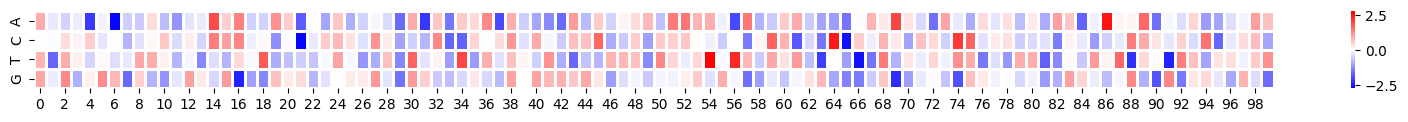

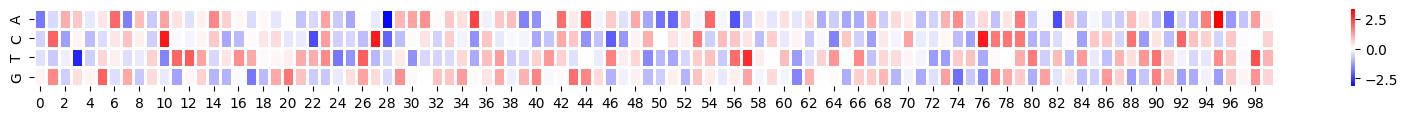

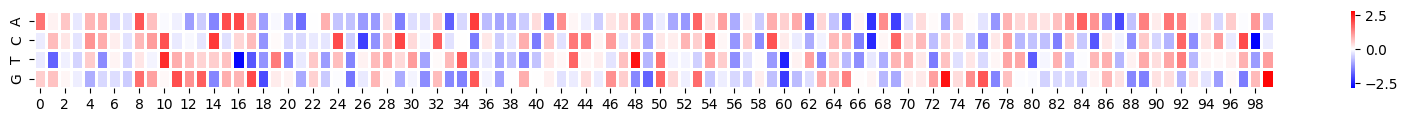

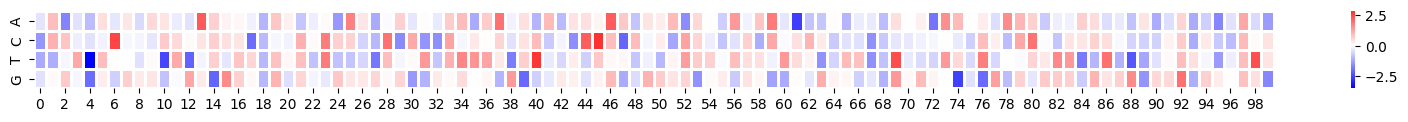

In [ ]:
sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
random_classes = sampled.to(device)
samples = sample(student_model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
n_print = 0
for image, class_show in zip(samples[-1], random_classes):
    if n_print < 4:
        plt.rcParams["figure.figsize"] = (20, 1)
        pd_seq = pd.DataFrame(image.reshape(4, 100))
        pd_seq.index = NUCLEOTIDES
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        plt.show()
        plt.rcParams["figure.figsize"] = (2, 2)
        n_print = n_print + 1

  0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

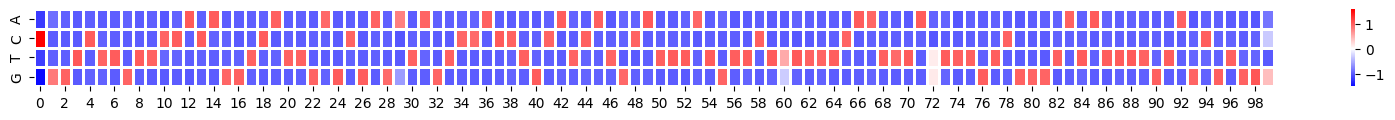

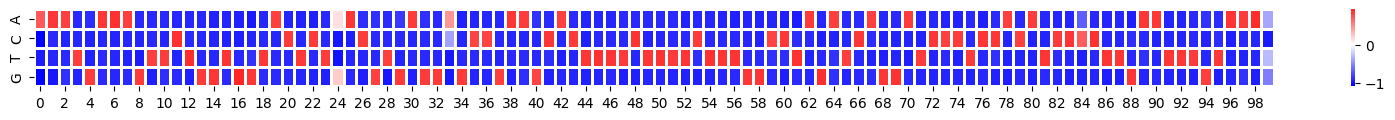

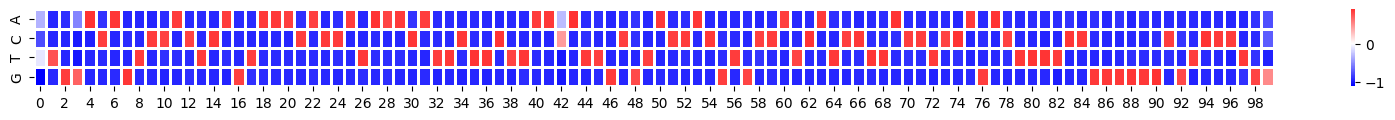

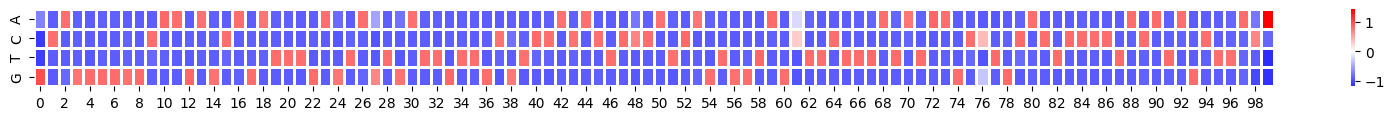

 Epoch 0 Train Loss: 0.01641562208533287 | Val Loss: 0.03406496943157707


KeyboardInterrupt: 

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(5)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 50 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

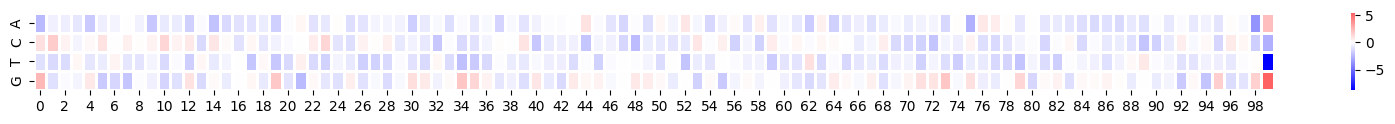

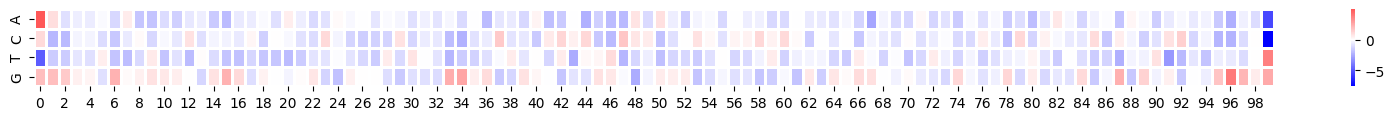

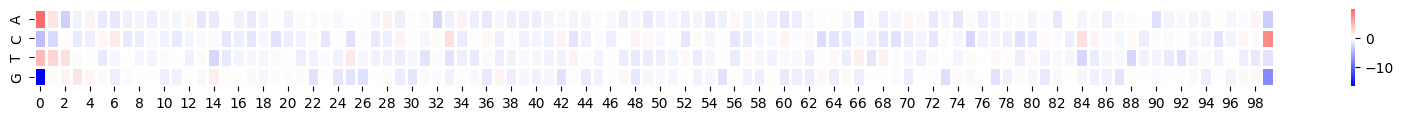

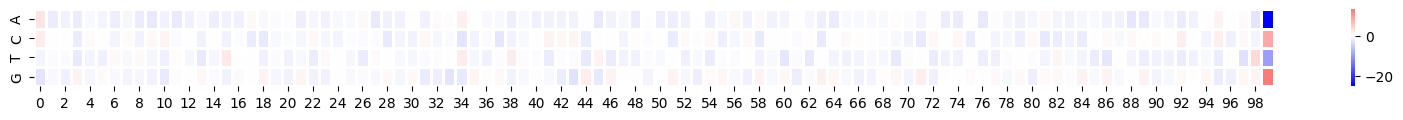

 Epoch 0 Train Loss: 0.07697286456823349 | Val Loss: 0.10253790938083428
 Epoch 1 Train Loss: 0.11554362624883652 | Val Loss: 0.08744304630250394
 Epoch 2 Train Loss: 0.08040070533752441 | Val Loss: 0.07329471430301175
 Epoch 3 Train Loss: 0.12467198818922043 | Val Loss: 0.06253673182800412
 Epoch 4 Train Loss: 0.09609320014715195 | Val Loss: 0.05644305516326774
 Epoch 5 Train Loss: 0.1177201196551323 | Val Loss: 0.04960480823329236
 Epoch 6 Train Loss: 0.05138104781508446 | Val Loss: 0.04423400020560182
 Epoch 7 Train Loss: 0.0468883216381073 | Val Loss: 0.04203455690060577
 Epoch 8 Train Loss: 0.05175485834479332 | Val Loss: 0.039964754459721565
 Epoch 9 Train Loss: 0.03142824396491051 | Val Loss: 0.03794987635172354
 Epoch 10 Train Loss: 0.025478631258010864 | Val Loss: 0.03703767400866541
 Epoch 11 Train Loss: 0.025528574362397194 | Val Loss: 0.03612920050794373
 Epoch 12 Train Loss: 0.07902217656373978 | Val Loss: 0.03536121296700751
 Epoch 13 Train Loss: 0.06510782241821289 | Val

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

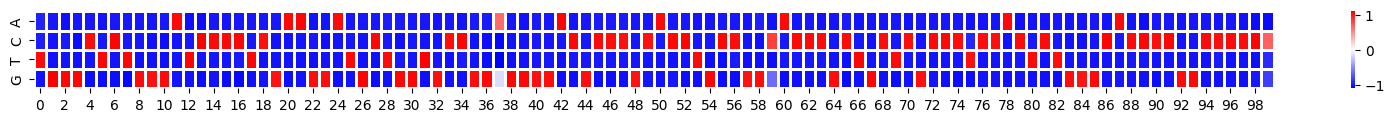

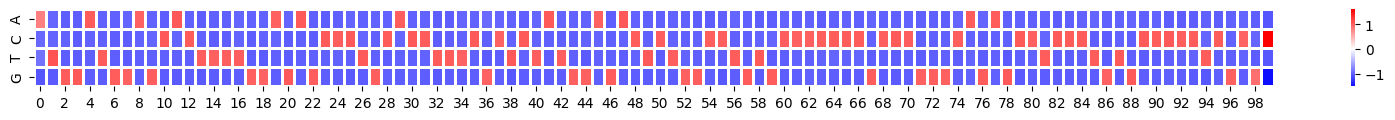

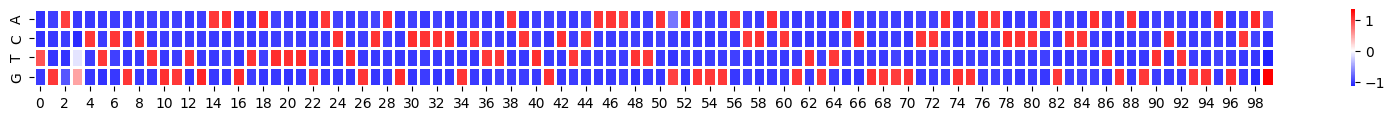

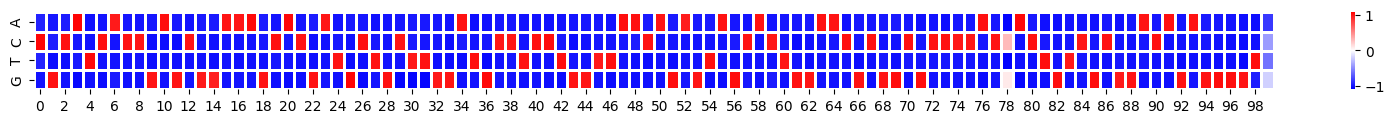

 Epoch 30 Train Loss: 0.01703387126326561 | Val Loss: 0.03278806132302448
 Epoch 31 Train Loss: 0.030033020302653313 | Val Loss: 0.031170669813337774
 Epoch 32 Train Loss: 0.03688373789191246 | Val Loss: 0.032224304885625416
 Epoch 33 Train Loss: 0.015228012576699257 | Val Loss: 0.03324236047821152
 Epoch 34 Train Loss: 0.07655936479568481 | Val Loss: 0.031741917767858764
 Epoch 35 Train Loss: 0.030188649892807007 | Val Loss: 0.03147062198280867
 Epoch 36 Train Loss: 0.025054050609469414 | Val Loss: 0.032565790579436434
 Epoch 37 Train Loss: 0.03374455124139786 | Val Loss: 0.03155853799281107
 Epoch 38 Train Loss: 0.021811768412590027 | Val Loss: 0.0317177084110841
 Epoch 39 Train Loss: 0.0028386067133396864 | Val Loss: 0.03116688269645186
 Epoch 40 Train Loss: 0.0495867021381855 | Val Loss: 0.03156416455146329
 Epoch 41 Train Loss: 0.01402987539768219 | Val Loss: 0.03190644403475116
 Epoch 42 Train Loss: 0.06441708654165268 | Val Loss: 0.03133642302425447
 Epoch 43 Train Loss: 0.04106

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

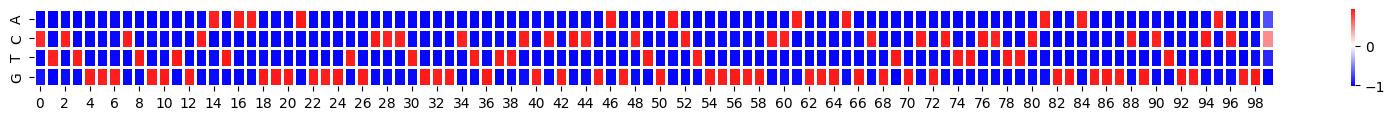

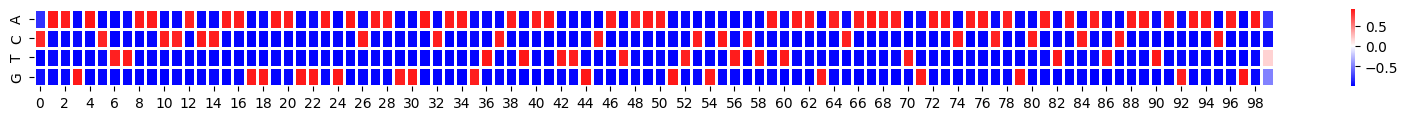

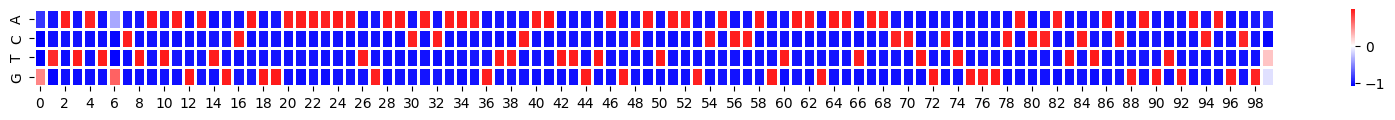

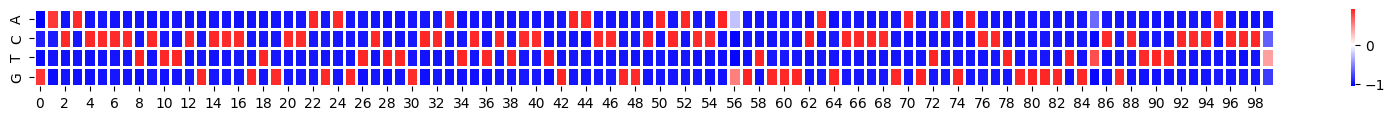

 Epoch 60 Train Loss: 0.02519037202000618 | Val Loss: 0.02957944252003376
 Epoch 61 Train Loss: 0.025853008031845093 | Val Loss: 0.031031963716259627
 Epoch 62 Train Loss: 0.04244261607527733 | Val Loss: 0.03063081121006381
 Epoch 63 Train Loss: 0.021304041147232056 | Val Loss: 0.029890420654382164
 Epoch 64 Train Loss: 0.01219682116061449 | Val Loss: 0.028773751353999975
 Epoch 65 Train Loss: 0.02562413178384304 | Val Loss: 0.029749358012933092
 Epoch 66 Train Loss: 0.01770932413637638 | Val Loss: 0.029440279980957672
 Epoch 67 Train Loss: 0.008308248594403267 | Val Loss: 0.02918326229133367
 Epoch 68 Train Loss: 0.031831882894039154 | Val Loss: 0.030467114756702558
 Epoch 69 Train Loss: 0.003304826794192195 | Val Loss: 0.029614106928337557
 Epoch 70 Train Loss: 0.06740915775299072 | Val Loss: 0.03161143812568774
 Epoch 71 Train Loss: 0.001980271888896823 | Val Loss: 0.02941135911006346
 Epoch 72 Train Loss: 0.052179884165525436 | Val Loss: 0.029611803956397075
 Epoch 73 Train Loss: 0

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

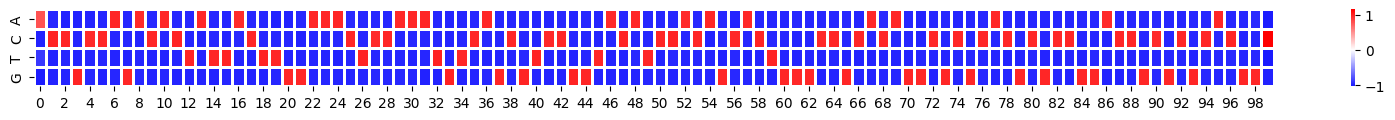

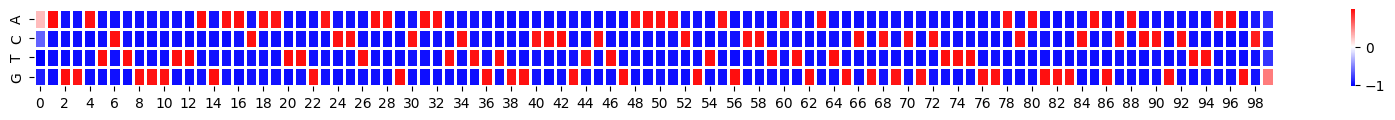

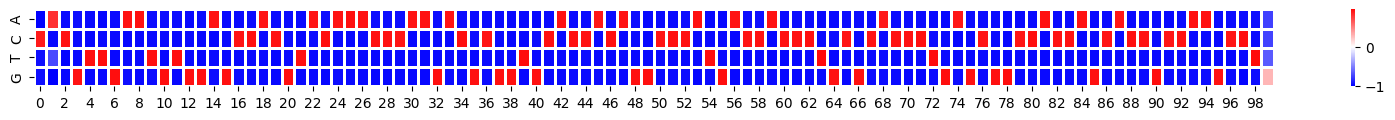

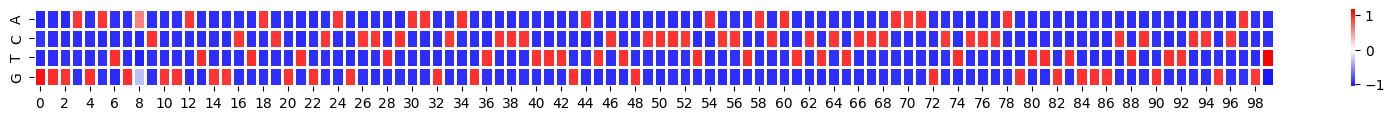

 Epoch 90 Train Loss: 0.011086376383900642 | Val Loss: 0.02904963584907727
 Epoch 91 Train Loss: 0.02268100716173649 | Val Loss: 0.028843081639231632
 Epoch 92 Train Loss: 0.026247048750519753 | Val Loss: 0.029649397653631362
 Epoch 93 Train Loss: 0.031335365027189255 | Val Loss: 0.028239933664221874
 Epoch 94 Train Loss: 0.07577493041753769 | Val Loss: 0.028748749170870502
 Epoch 95 Train Loss: 0.04353770241141319 | Val Loss: 0.02876840242268035
 Epoch 96 Train Loss: 0.017012061551213264 | Val Loss: 0.02988368369678395
 Epoch 97 Train Loss: 0.011622018180787563 | Val Loss: 0.028115495015228142
 Epoch 98 Train Loss: 0.07020003348588943 | Val Loss: 0.029375759452680825
 Epoch 99 Train Loss: 0.09025576710700989 | Val Loss: 0.030294975158765773
 Epoch 100 Train Loss: 0.01961187832057476 | Val Loss: 0.030258745092495085
 Epoch 101 Train Loss: 0.02472090534865856 | Val Loss: 0.029067183251154947
 Epoch 102 Train Loss: 0.025061165913939476 | Val Loss: 0.02826714252042796
 Epoch 103 Train Los

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

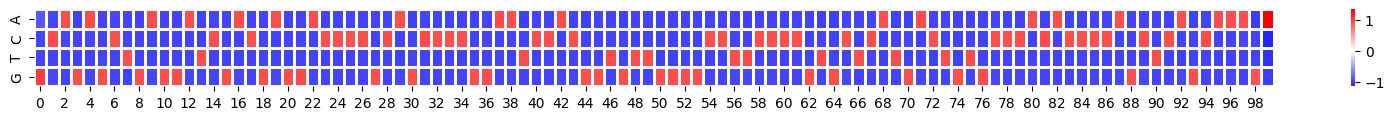

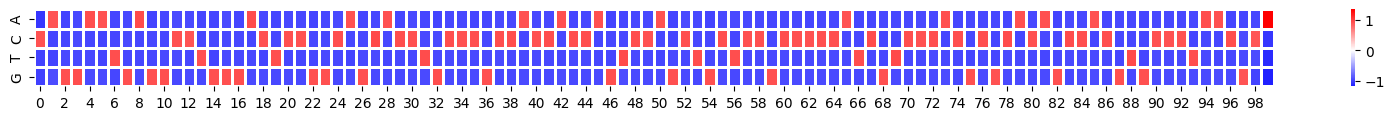

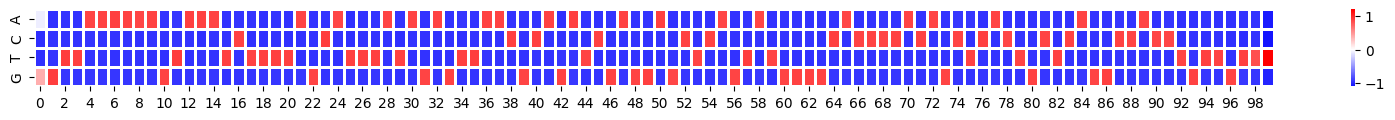

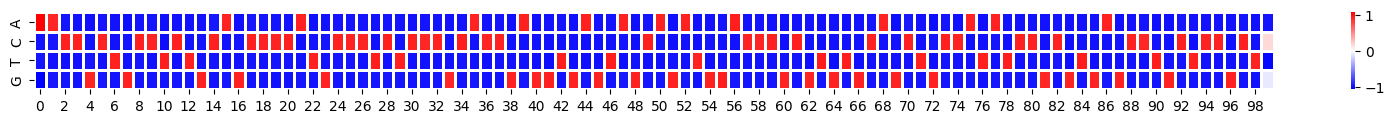

 Epoch 120 Train Loss: 0.025907838717103004 | Val Loss: 0.030228019425180542
 Epoch 121 Train Loss: 0.058557845652103424 | Val Loss: 0.02867517349828514
 Epoch 122 Train Loss: 0.026768619194626808 | Val Loss: 0.028290231094448542
 Epoch 123 Train Loss: 0.0291021466255188 | Val Loss: 0.028053076928656905
 Epoch 124 Train Loss: 0.07160580158233643 | Val Loss: 0.027357561392431826
 Epoch 125 Train Loss: 0.018951304256916046 | Val Loss: 0.02831805036863783
 Epoch 126 Train Loss: 0.022279009222984314 | Val Loss: 0.02827529279768081
 Epoch 127 Train Loss: 0.0327274315059185 | Val Loss: 0.02744759048362302
 Epoch 128 Train Loss: 0.011416012421250343 | Val Loss: 0.027388462486122755
 Epoch 129 Train Loss: 0.021433813497424126 | Val Loss: 0.028594701538839067
 Epoch 130 Train Loss: 0.03981629014015198 | Val Loss: 0.02806802041458735
 Epoch 131 Train Loss: 0.02779092825949192 | Val Loss: 0.028559106855333038
 Epoch 132 Train Loss: 0.04214238375425339 | Val Loss: 0.027855724195717267
 Epoch 133 T

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

# Plotting
# plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Validation Loss SP-MSE')
# plt.legend()
# plt.grid(True)

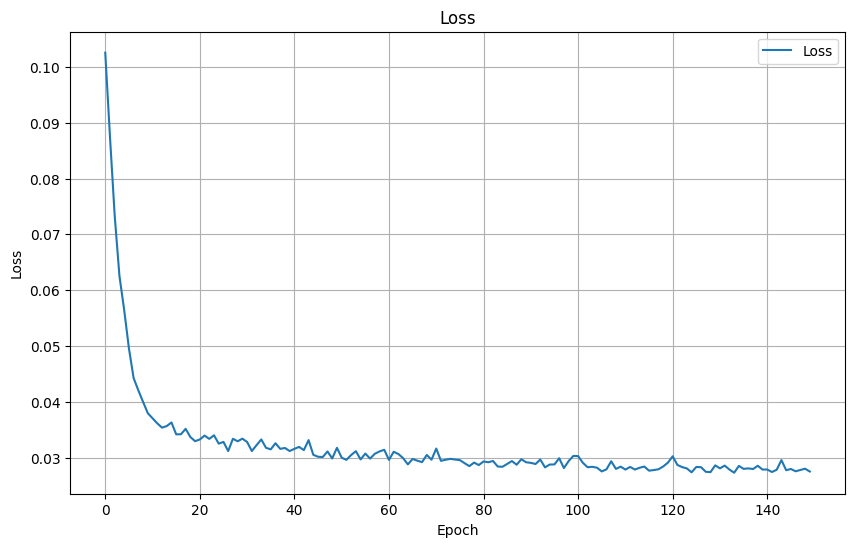

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(len(val_loss_values)), val_loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

In [ ]:
torch.save(model.state_dict(), 'diff_zdna_100.pth')

In [ ]:
sampling_reverse_encoding(20)

<ipython-input-21-2cdf4ce58126>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_a in tqdm_notebook(range(number_of_samples)):


  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
gen_seqs = []
fasta_files = [
    'synthetic_seqs.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    gen_seqs.append(str(record.seq).upper())

generated_dataset = pd.DataFrame({"raw_sequence": gen_seqs})
generated_dataset.head()

raw_sequence
0  TAGAAGGAAGTGTGAATAATTCTGAGAAAAAAACACGGCCGGCGAT...
1  TGGGGTGCTGGGAGGCCAGTCCGCCGCAGGCCGCCCGGGCCCAGCA...
2  AGTTTTTGCATACTTGAATCTAGGTGCACAAATACAGACACAAACT...
3  GGCGCGGGCGCGCGCGGCCGCTGAGGCCGGGGAGTGCCAGGGGCTC...
4  ATCCGTCTAAGTCTGAATTGCGCAAGGTGTGTGGGGCTTGGCTGGT...

In [ ]:
generated_dataset.shape

(320, 1)

In [ ]:
raw_dataset[:320]

raw_sequence    type  label
0    TGTTCTCCGAGATCCTGAAACCACGCGAACCGTGAAGCGCCCGGCG...  G-quad      0
1    CACCACCAGCCGCCTAACAGCTCCGCCTCCAGCAGCGCGCCTGGGC...   Z-DNA      1
2    TCACGGGAGCTCTGGAGAGGACTCGCCAACCCAGAACGGGTATTTT...   Z-DNA      1
3    GGACCGGGATGAATTTCAGAGGTGAGTTGTGGGTGGAAGGGCTGGG...   Z-DNA      1
4    CGCACGAGGACGGACAGGGCTCCCTACACGAACAGGGTTGTTTGGA...  G-quad      0
..                                                 ...     ...    ...
315  CTTGCTGGTCCTCAGAGGCCCTTGAGGTTTCAGGCCAAGGCTGGGG...   Z-DNA      1
316  GGCTTGGGAGCCGCCGCCGGCGCCAACTTTTCCCATCGCGGGAGCG...   Z-DNA      1
317  AGGCGCCGCCCGGCGGCCGCGGCCCTTCGCCGCAGCCAGAGTGCTT...   Z-DNA      1
318  TAGTCTGAATGAAAGGGCAGGACAGCTCAGCCTCCTCCCTGAACAG...   Z-DNA      1
319  CCCTCAGCTCAGGGTTCTGAGGCCTGCAGGAGCCCGGGGCAGCGCC...  G-quad      0

[320 rows x 3 columns]

In [ ]:
set_all_data = set(generated_dataset.index.values.tolist() + raw_dataset[:320].index.values.tolist())
create_new_matrix = []
for x in set_all_data:
    list_in = []
    list_in.append(x)  # adding the name
    if x in generated_dataset.index:
        list_in.append(generated_dataset.loc[x][0])
    else:
        list_in.append(1)

    if x in raw_dataset[:320].index:
        list_in.append(raw_dataset[:320].loc[x][0])
    else:
        list_in.append(1)

    create_new_matrix.append(list_in)

#Load trained model

In [ ]:
PATH = "/content/diff_zdna_100.pth"

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

sampling loop time step:   0%|          | 0/1 [00:00<?, ?it/s]

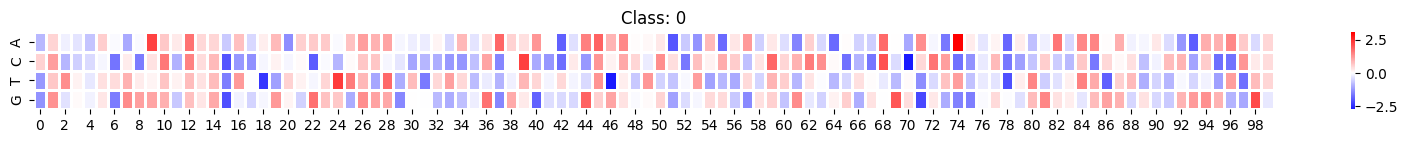

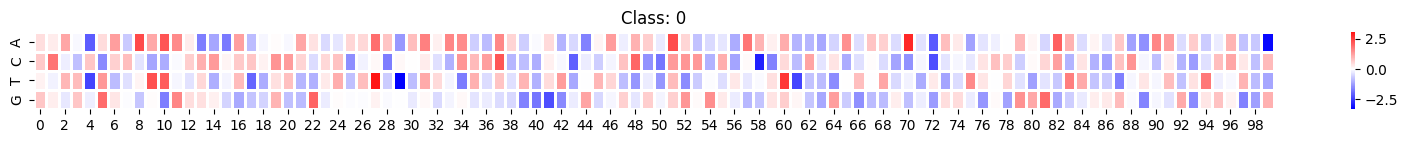

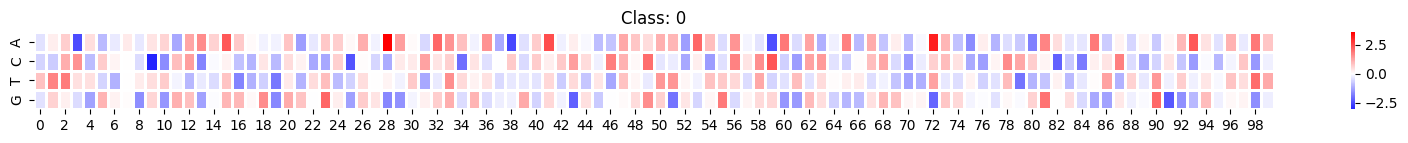

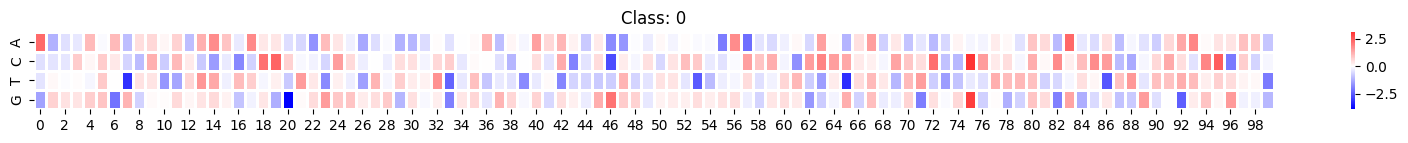

In [ ]:
model.eval()
sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
random_classes = sampled.to(device)
samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
n_print = 0
for image, class_show in zip(samples[-1], random_classes):
    if n_print < 4:
        plt.rcParams["figure.figsize"] = (20, 1)
        pd_seq = pd.DataFrame(image.reshape(4, 100))
        pd_seq.index = NUCLEOTIDES
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        plt.title(f'Class: {class_show}')
        plt.show()
        plt.rcParams["figure.figsize"] = (2, 2)
        n_print = n_print + 1

In [ ]:
@torch.no_grad()
def p_sample_loop_t(model, classes, shape, cond_weight):
    device = next(model.parameters()).device
    timesteps = 10
    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0
        sampling_fn = partial(p_sample_guided, classes=classes, cond_weight=cond_weight, context_mask=context_mask)
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = sampling_fn(model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample_t(model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0):
    return p_sample_loop_t(model, classes=classes, shape=(batch_size, channels, 4, image_size), cond_weight=cond_weight)

In [ ]:
def sampling_reverse_encoding(number_of_samples, specific_group=False, group_number=None, cond_weight_to_metric=0):
    """
    Stands for reverse encoding
    """
    final_sequences = []
    for n_a in tqdm(range(number_of_samples)):  # Use tqdm instead of tqdm_notebook
        sample_bs = 16
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample_t(
            model,
            classes=random_classes,
            image_size=100,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 100), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_seqs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()

In [ ]:
%%capture
%%time
n = 1000
synt_df = sampling_reverse_encoding(n)

In [ ]:
%%capture
%%time
n = 1000
synt_df = sampling_reverse_encoding(n)

In [ ]:
%%capture
%%time
n = 1000
synt_df = sampling_reverse_encoding(n)

In [ ]:
%%capture
n = 87500
synt_df = sampling_reverse_encoding(n)

In [ ]:
fasta_file_path = "/content/synthetic_seqs.fasta"
with open(fasta_file_path, 'r') as fasta_file:
    fasta_lines = fasta_file.readlines()

In [ ]:
fasta_file_path = "/content/synthetic_seqs.fasta"
with open(fasta_file_path, 'r') as fasta_file:
    fasta_lines = fasta_file.readlines()
fasta_lines = fasta_lines[:-8]
for i, line in enumerate(fasta_lines):
    if line.startswith('>seq_test_'):
        chrom_index = i % len(un_bed_dataset.chrom)
        chromosome_name = un_bed_dataset.chrom[chrom_index]
        fasta_lines[i] = f'> {chromosome_name}\n'

updated_fasta_file_path = 'diff_generated_sequences_100.fasta'
with open(updated_fasta_file_path, 'w') as updated_fasta_file:
    updated_fasta_file.writelines(fasta_lines)

In [ ]:
# optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()

# Long train

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 0 Train Loss: 0.09748658537864685 | Val Loss: 0.08182994061469162
 Epoch 1 Train Loss: 0.06626124680042267 | Val Loss: 0.07606544046506394
 Epoch 2 Train Loss: 0.03424541652202606 | Val Loss: 0.06866879483861645
 Epoch 3 Train Loss: 0.06668582558631897 | Val Loss: 0.0670614141127924
 Epoch 4 Train Loss: 0.06383757293224335 | Val Loss: 0.0636768728277109
 Epoch 5 Train Loss: 0.07695277035236359 | Val Loss: 0.05600544750472925
 Epoch 6 Train Loss: 0.06622965633869171 | Val Loss: 0.05527690637611995
 Epoch 7 Train Loss: 0.04107637703418732 | Val Loss: 0.05214451027041587
 Epoch 8 Train Loss: 0.03946952521800995 | Val Loss: 0.046243593151116896
 Epoch 9 Train Loss: 0.030001185834407806 | Val Loss: 0.048972673415050016
 Epoch 10 Train Loss: 0.04410595819354057 | Val Loss: 0.04311715928416183
 Epoch 11 Train Loss: 0.03797910735011101 | Val Loss: 0.04449226251755753
 Epoch 12 Train Loss: 0.020407233387231827 | Val Loss: 0.044153045400650834
 Epoch 13 Train Loss: 0.03453811630606651 | V

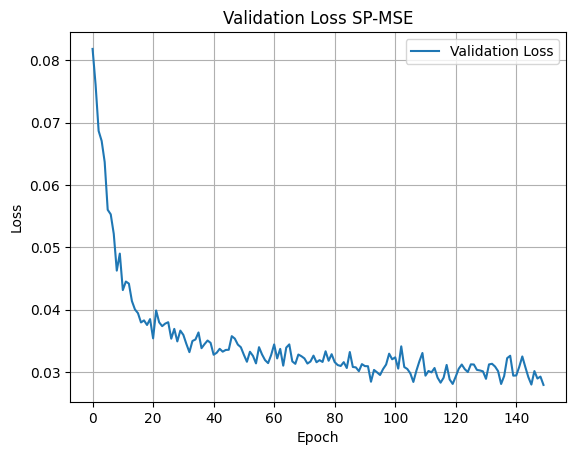

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches

    # if epoch:
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

# Plotting
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss SP-MSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
PATH = "/content/drive/My Drive/data_for_gans/model_grok.pt"

In [ ]:
torch.save(model.state_dict(), PATH)

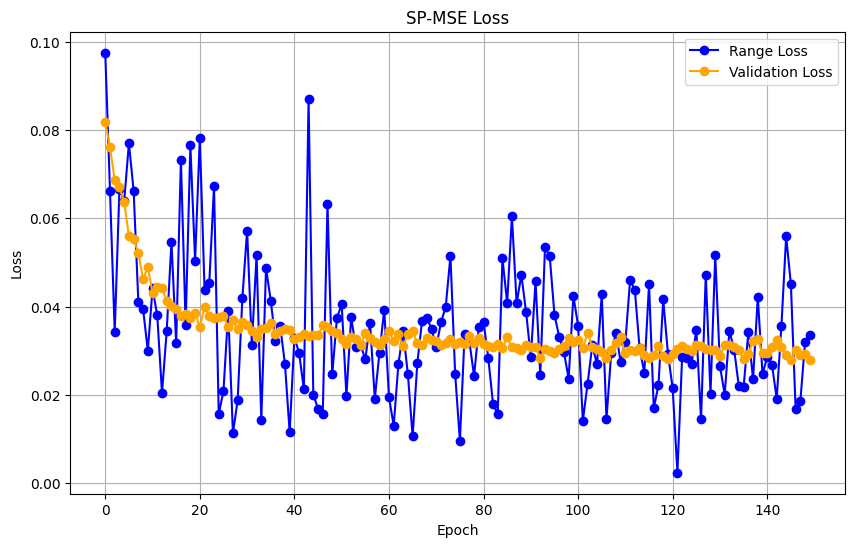

In [ ]:
plt.figure(figsize=(10, 6))

# Training Loss
plt.plot(range(len(val_loss_values)), train_loss_values, marker='o', label='Range Loss', color='blue')

# Validation Loss
plt.plot(range(len(val_loss_values)), val_loss_values, marker='o', label='Validation Loss', color='orange')

# Styling
plt.title('SP-MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(20)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.6
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches

    # if epoch:
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

# Plotting
plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss SP-MSE')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

 Epoch 0 Train Loss: 0.03989439830183983 | Val Loss: 0.02907524072993411
 Epoch 1 Train Loss: 0.02063530683517456 | Val Loss: 0.029641545438853494
 Epoch 2 Train Loss: 0.03293796256184578 | Val Loss: 0.030345986107785772
 Epoch 3 Train Loss: 0.02678436040878296 | Val Loss: 0.029376551141812854
 Epoch 4 Train Loss: 0.021392323076725006 | Val Loss: 0.02943749893048819
 Epoch 5 Train Loss: 0.03250754624605179 | Val Loss: 0.03156723844798377
 Epoch 6 Train Loss: 0.019475797191262245 | Val Loss: 0.029268676251934394
 Epoch 7 Train Loss: 0.015969103202223778 | Val Loss: 0.028202332943732287
 Epoch 8 Train Loss: 0.021784266456961632 | Val Loss: 0.027885063432401765
 Epoch 9 Train Loss: 0.0357150062918663 | Val Loss: 0.03097993371342003
 Epoch 10 Train Loss: 0.01935979723930359 | Val Loss: 0.029895960326122975
 Epoch 11 Train Loss: 0.02422049269080162 | Val Loss: 0.02989063787199285


KeyboardInterrupt: ignored

# Losses

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
optimizer = Adam(model1.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

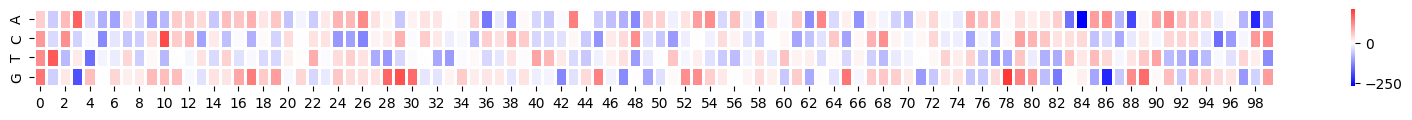

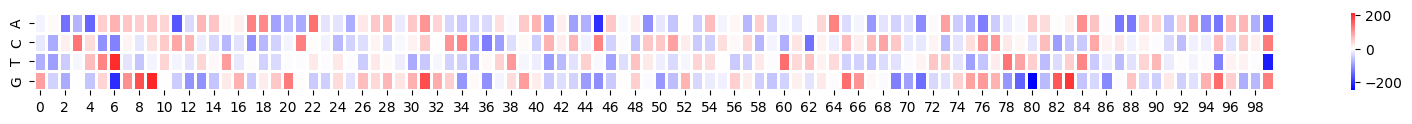

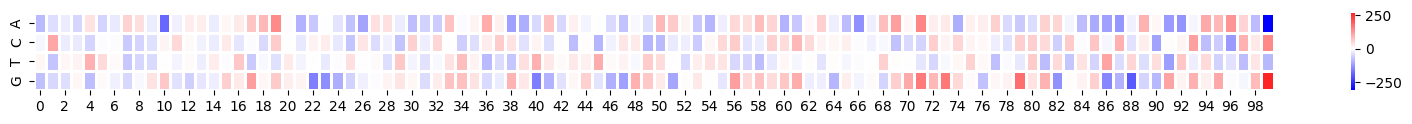

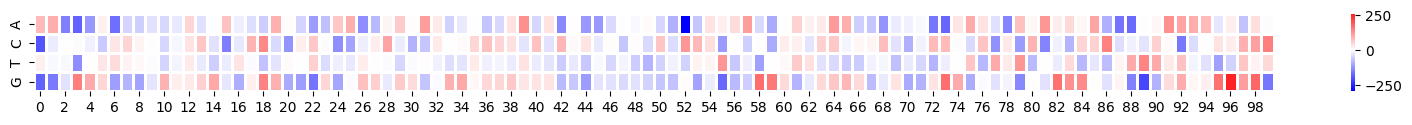

 Epoch 0 Train Loss: 0.4464009702205658 | Val Loss: 0.4288613200187683
 Epoch 1 Train Loss: 0.39425167441368103 | Val Loss: 0.3423935251295074
 Epoch 2 Train Loss: 0.27067193388938904 | Val Loss: 0.29986702188972597
 Epoch 3 Train Loss: 0.28544577956199646 | Val Loss: 0.2843701862845539
 Epoch 4 Train Loss: 0.21355712413787842 | Val Loss: 0.27798584005064214
 Epoch 5 Train Loss: 0.31371182203292847 | Val Loss: 0.2697472642522213
 Epoch 6 Train Loss: 0.12326858937740326 | Val Loss: 0.2598297206823491
 Epoch 7 Train Loss: 0.23895995318889618 | Val Loss: 0.24773670474359813
 Epoch 8 Train Loss: 0.16314001381397247 | Val Loss: 0.24123122068968686
 Epoch 9 Train Loss: 0.2777339518070221 | Val Loss: 0.24038951049658877
 Epoch 10 Train Loss: 0.2546294331550598 | Val Loss: 0.22692062428667525
 Epoch 11 Train Loss: 0.20210517942905426 | Val Loss: 0.21825040704455256
 Epoch 12 Train Loss: 0.3598993718624115 | Val Loss: 0.22239676641284928
 Epoch 13 Train Loss: 0.1559477150440216 | Val Loss: 0.21

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

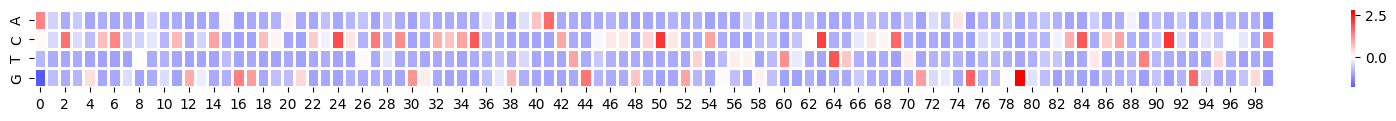

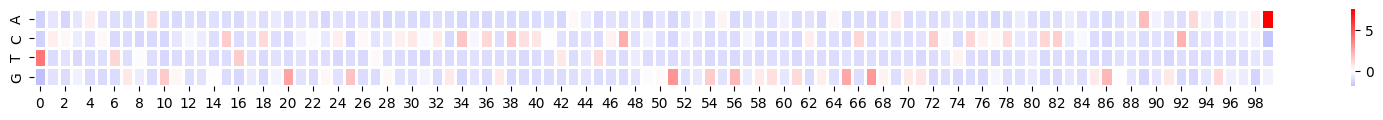

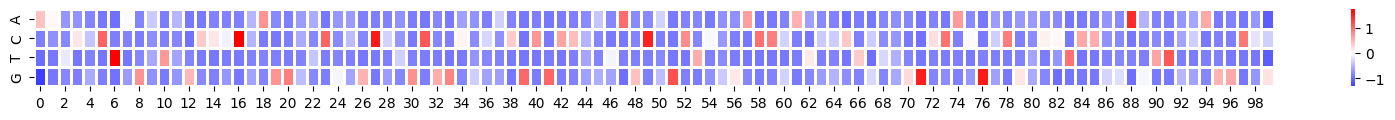

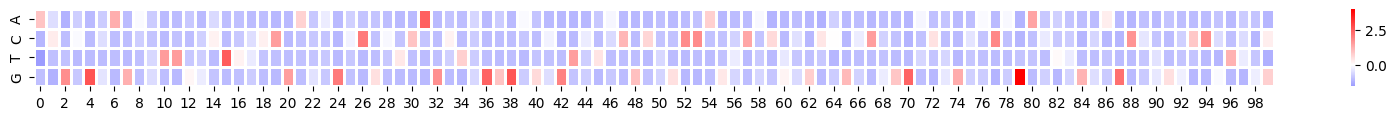

 Epoch 30 Train Loss: 0.1897014081478119 | Val Loss: 0.17396254055509883
 Epoch 31 Train Loss: 0.17990541458129883 | Val Loss: 0.1658845120225071
 Epoch 32 Train Loss: 0.24699991941452026 | Val Loss: 0.16615162414213844
 Epoch 33 Train Loss: 0.12463416159152985 | Val Loss: 0.16509269288748749
 Epoch 34 Train Loss: 0.15088729560375214 | Val Loss: 0.16604702407109342
 Epoch 35 Train Loss: 0.1616111695766449 | Val Loss: 0.16184684147765813
 Epoch 36 Train Loss: 0.1810753345489502 | Val Loss: 0.16970962464563116
 Epoch 37 Train Loss: 0.16934841871261597 | Val Loss: 0.16285540816212488
 Epoch 38 Train Loss: 0.2066888064146042 | Val Loss: 0.1622409614895986
 Epoch 39 Train Loss: 0.13857059180736542 | Val Loss: 0.1595601179629318
 Epoch 40 Train Loss: 0.20493221282958984 | Val Loss: 0.16164683932361523
 Epoch 41 Train Loss: 0.15321798622608185 | Val Loss: 0.15990331910612168
 Epoch 42 Train Loss: 0.10041126608848572 | Val Loss: 0.16250588443161043
 Epoch 43 Train Loss: 0.1606156826019287 | Va

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

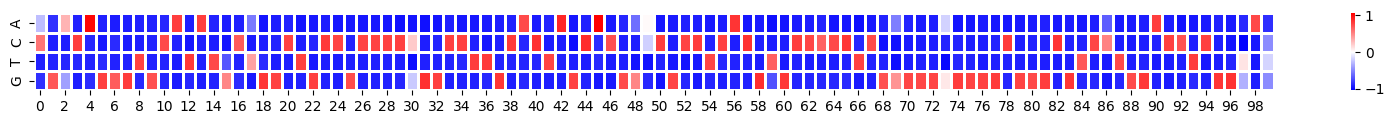

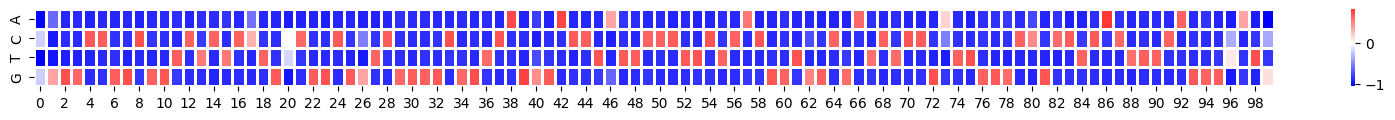

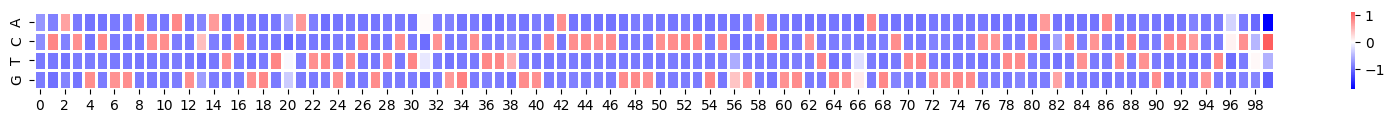

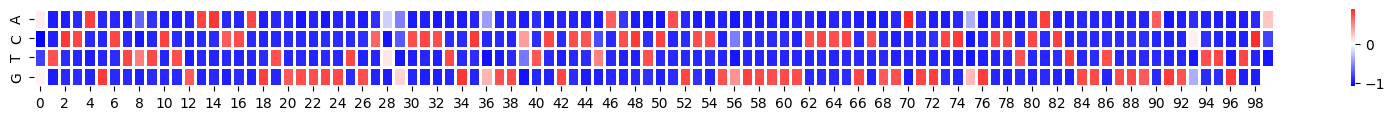

 Epoch 60 Train Loss: 0.11730055510997772 | Val Loss: 0.1309645560777877
 Epoch 61 Train Loss: 0.12381841242313385 | Val Loss: 0.13104860576962638
 Epoch 62 Train Loss: 0.12441002577543259 | Val Loss: 0.12710451593330083
 Epoch 63 Train Loss: 0.10150866210460663 | Val Loss: 0.1266224015165459
 Epoch 64 Train Loss: 0.1363268792629242 | Val Loss: 0.131790895292089
 Epoch 65 Train Loss: 0.13729539513587952 | Val Loss: 0.1265695044570718
 Epoch 66 Train Loss: 0.09892307966947556 | Val Loss: 0.1317862537035272
 Epoch 67 Train Loss: 0.14833907783031464 | Val Loss: 0.12724375201404586
 Epoch 68 Train Loss: 0.14790908992290497 | Val Loss: 0.13265566915766266
 Epoch 69 Train Loss: 0.09882533550262451 | Val Loss: 0.1272505834575527
 Epoch 70 Train Loss: 0.1451144963502884 | Val Loss: 0.12421388573144093
 Epoch 71 Train Loss: 0.1394646018743515 | Val Loss: 0.12335094861870954
 Epoch 72 Train Loss: 0.1546950340270996 | Val Loss: 0.1254857631692709
 Epoch 73 Train Loss: 0.14353013038635254 | Val Lo

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

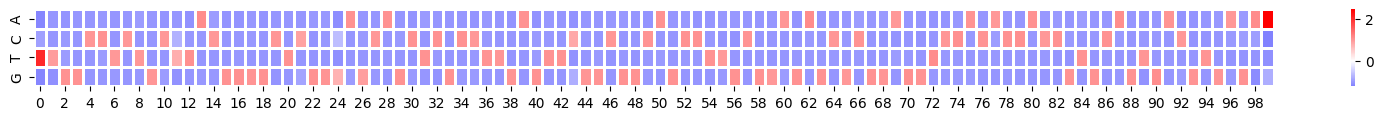

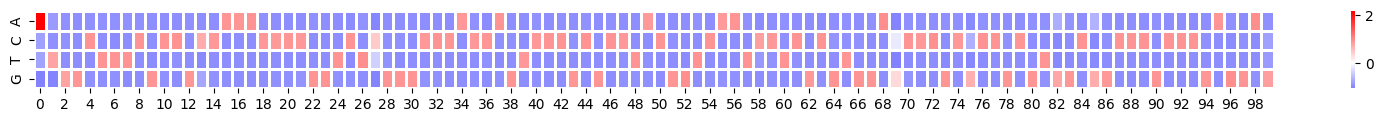

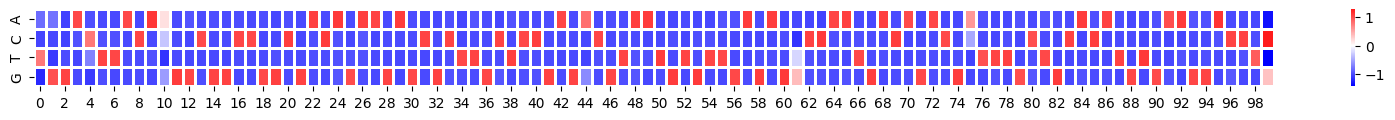

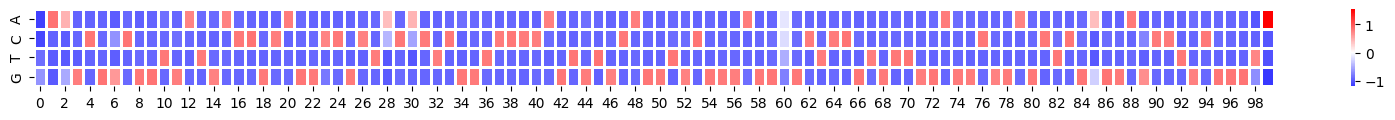

 Epoch 90 Train Loss: 0.10275399684906006 | Val Loss: 0.11646320362967894
 Epoch 91 Train Loss: 0.11897267401218414 | Val Loss: 0.11578159822412759
 Epoch 92 Train Loss: 0.11652948707342148 | Val Loss: 0.11457980245598091
 Epoch 93 Train Loss: 0.13003695011138916 | Val Loss: 0.11653409498043296
 Epoch 94 Train Loss: 0.11065778136253357 | Val Loss: 0.11510787990467608
 Epoch 95 Train Loss: 0.08723323047161102 | Val Loss: 0.11807845200388885
 Epoch 96 Train Loss: 0.11302095651626587 | Val Loss: 0.11140011454170401
 Epoch 97 Train Loss: 0.09049907326698303 | Val Loss: 0.11339216362223152
 Epoch 98 Train Loss: 0.146851047873497 | Val Loss: 0.11054967072877017
 Epoch 99 Train Loss: 0.11173930019140244 | Val Loss: 0.11152041297067296
 Epoch 100 Train Loss: 0.0727849155664444 | Val Loss: 0.11435608999911419
 Epoch 101 Train Loss: 0.17786036431789398 | Val Loss: 0.11153437877612665
 Epoch 102 Train Loss: 0.1126772090792656 | Val Loss: 0.114321352960157
 Epoch 103 Train Loss: 0.0962406173348426

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

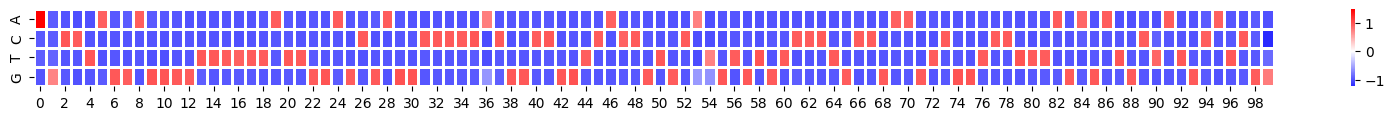

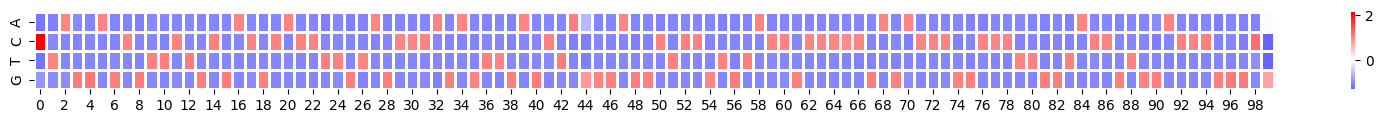

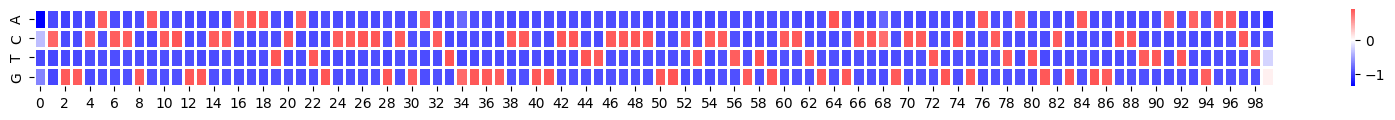

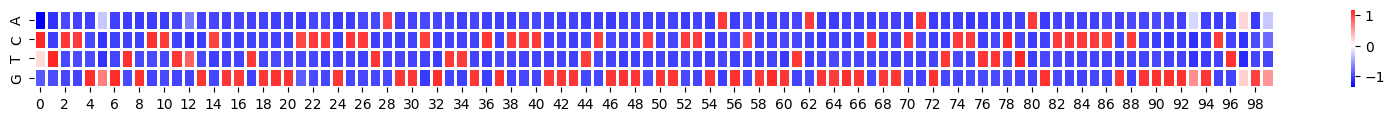

 Epoch 120 Train Loss: 0.13806046545505524 | Val Loss: 0.10846356086987109
 Epoch 121 Train Loss: 0.09089604765176773 | Val Loss: 0.11202287858675335
 Epoch 122 Train Loss: 0.0802275761961937 | Val Loss: 0.10819156615694692
 Epoch 123 Train Loss: 0.07686541229486465 | Val Loss: 0.11165404338235697
 Epoch 124 Train Loss: 0.12105971574783325 | Val Loss: 0.11050838195095378
 Epoch 125 Train Loss: 0.13188648223876953 | Val Loss: 0.10819003961918768
 Epoch 126 Train Loss: 0.08791330456733704 | Val Loss: 0.10724214433638518
 Epoch 127 Train Loss: 0.13791973888874054 | Val Loss: 0.1069411916796826
 Epoch 128 Train Loss: 0.09598305076360703 | Val Loss: 0.10608764473071769
 Epoch 129 Train Loss: 0.11107824742794037 | Val Loss: 0.11651112798078
 Epoch 130 Train Loss: 0.10860465466976166 | Val Loss: 0.11426313701739982
 Epoch 131 Train Loss: 0.11073379218578339 | Val Loss: 0.1117487144617995
 Epoch 132 Train Loss: 0.08750471472740173 | Val Loss: 0.1068767732825161
 Epoch 133 Train Loss: 0.1061991

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="l1")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="l1").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

In [ ]:
val_loss_values

[0.4288613200187683,
 0.3423935251295074,
 0.29986702188972597,
 0.2843701862845539,
 0.27798584005064214,
 0.2697472642522213,
 0.2598297206823491,
 0.24773670474359813,
 0.24123122068968686,
 0.24038951049658877,
 0.22692062428667525,
 0.21825040704455256,
 0.22239676641284928,
 0.21266418966380032,
 0.2066446018120474,
 0.20354399940938003,
 0.19853714089994587,
 0.19522933939025422,
 0.19690761733646236,
 0.1968921544261215,
 0.18948017731924688,
 0.18967607740528328,
 0.18886931905569124,
 0.1771301040348928,
 0.17609114039781665,
 0.1814485091931564,
 0.18193199842675659,
 0.17767759067706826,
 0.17671506082223468,
 0.1704530597718294,
 0.17396254055509883,
 0.1658845120225071,
 0.16615162414213844,
 0.16509269288748749,
 0.16604702407109342,
 0.16184684147765813,
 0.16970962464563116,
 0.16285540816212488,
 0.1622409614895986,
 0.1595601179629318,
 0.16164683932361523,
 0.15990331910612168,
 0.16250588443161043,
 0.1555511053990234,
 0.14988503346512141,
 0.1528297192301632,
 0.

In [ ]:
model1 = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model1.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

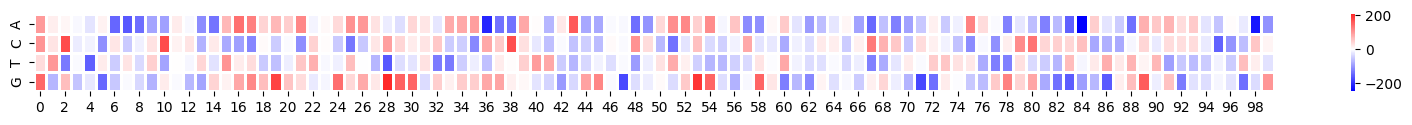

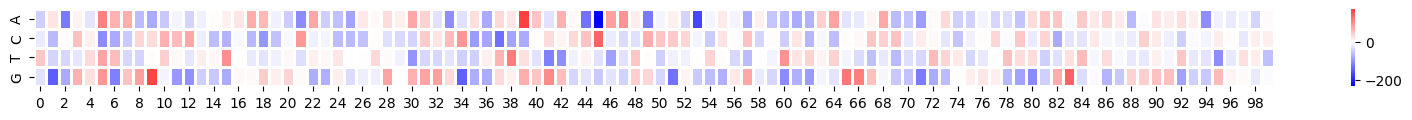

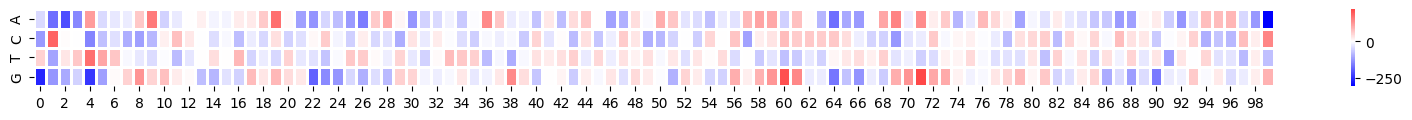

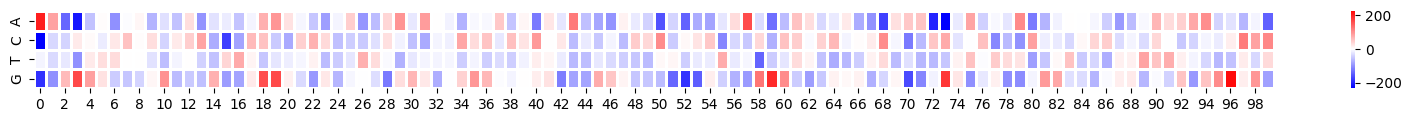

 Epoch 0 Train Loss: 0.3474540710449219 | Val Loss: 0.35029621877946143
 Epoch 1 Train Loss: 0.3628624975681305 | Val Loss: 0.26809011122658233
 Epoch 2 Train Loss: 0.17329882085323334 | Val Loss: 0.23500930859653418
 Epoch 3 Train Loss: 0.2812846899032593 | Val Loss: 0.21987501134680323
 Epoch 4 Train Loss: 0.25956079363822937 | Val Loss: 0.21847696768597138
 Epoch 5 Train Loss: 0.2366960346698761 | Val Loss: 0.20916146834280866
 Epoch 6 Train Loss: 0.31197652220726013 | Val Loss: 0.20098623239304408
 Epoch 7 Train Loss: 0.0791131779551506 | Val Loss: 0.19046317314929215
 Epoch 8 Train Loss: 0.06238714978098869 | Val Loss: 0.1816163857367413
 Epoch 9 Train Loss: 0.1531684249639511 | Val Loss: 0.1831045263747046
 Epoch 10 Train Loss: 0.1695009171962738 | Val Loss: 0.1671462206801107
 Epoch 11 Train Loss: 0.14528049528598785 | Val Loss: 0.15606795719339828
 Epoch 12 Train Loss: 0.1873876005411148 | Val Loss: 0.15825017049046589
 Epoch 13 Train Loss: 0.1711149960756302 | Val Loss: 0.1488

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

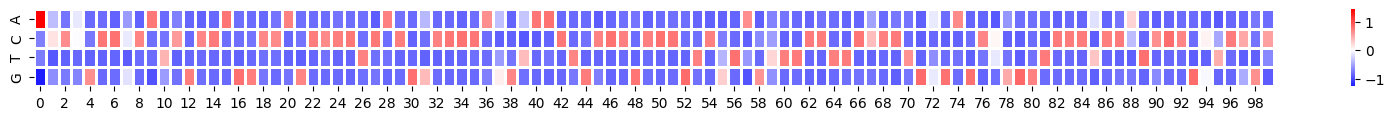

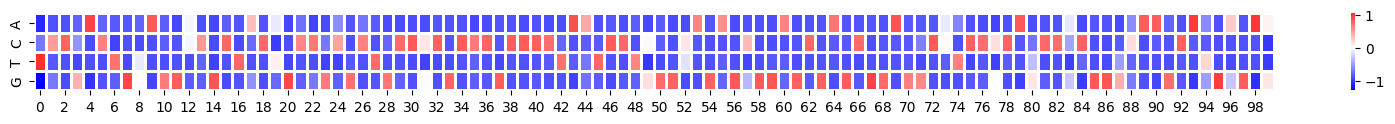

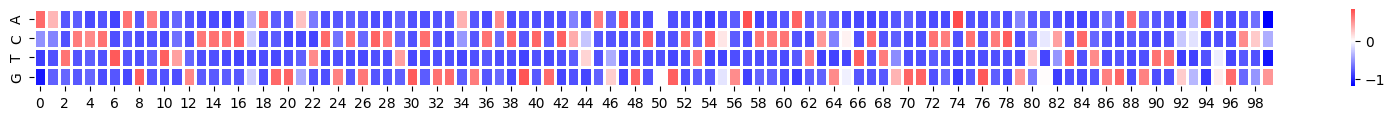

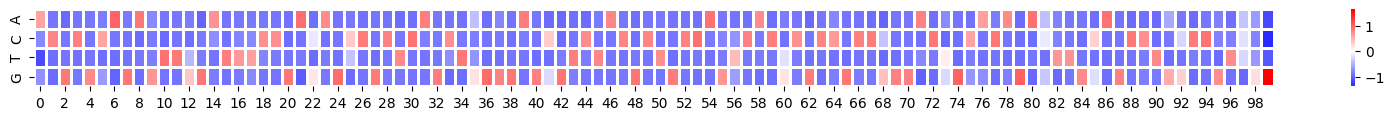

 Epoch 30 Train Loss: 0.10278498381376266 | Val Loss: 0.09695394715863812
 Epoch 31 Train Loss: 0.11241323500871658 | Val Loss: 0.0928147405324396
 Epoch 32 Train Loss: 0.08588045090436935 | Val Loss: 0.0949432446259605
 Epoch 33 Train Loss: 0.23216785490512848 | Val Loss: 0.09272298543167508
 Epoch 34 Train Loss: 0.06463077664375305 | Val Loss: 0.09455008712435557
 Epoch 35 Train Loss: 0.07748138159513474 | Val Loss: 0.08797572106738721
 Epoch 36 Train Loss: 0.12913517653942108 | Val Loss: 0.09254039405298627
 Epoch 37 Train Loss: 0.061009831726551056 | Val Loss: 0.08845179681935586
 Epoch 38 Train Loss: 0.05815918371081352 | Val Loss: 0.09017710524711235
 Epoch 39 Train Loss: 0.08637510985136032 | Val Loss: 0.08823544550533137
 Epoch 40 Train Loss: 0.11436893790960312 | Val Loss: 0.08881522879804954
 Epoch 41 Train Loss: 0.06623758375644684 | Val Loss: 0.08687365658519682
 Epoch 42 Train Loss: 0.0709979236125946 | Val Loss: 0.08764253864603594
 Epoch 43 Train Loss: 0.1017227396368980

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

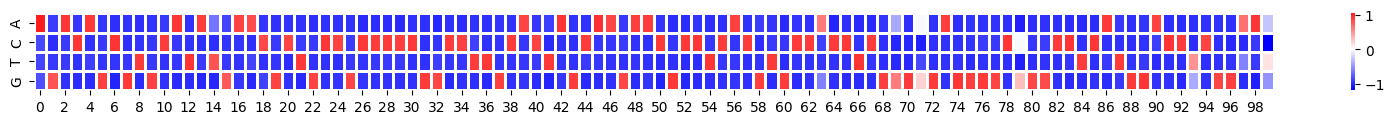

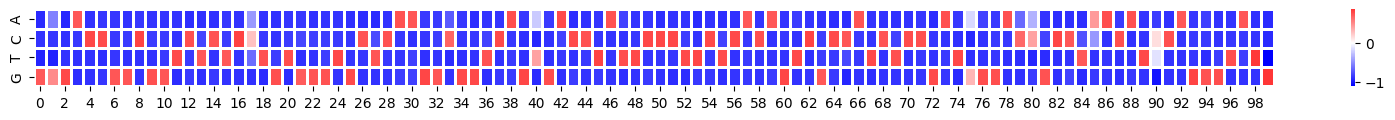

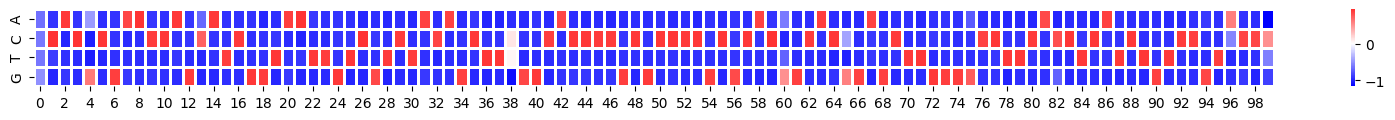

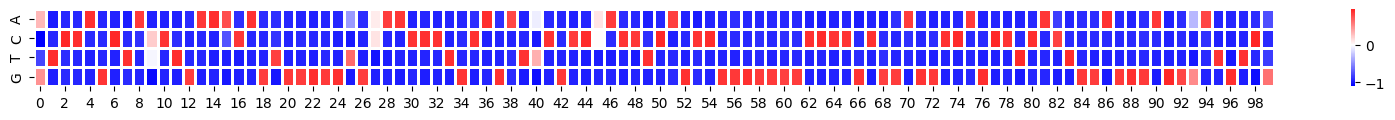

 Epoch 60 Train Loss: 0.1051810160279274 | Val Loss: 0.07949773459271951
 Epoch 61 Train Loss: 0.05702630802989006 | Val Loss: 0.07765311209007728
 Epoch 62 Train Loss: 0.0727987065911293 | Val Loss: 0.07621571239976843
 Epoch 63 Train Loss: 0.051615159958601 | Val Loss: 0.07520137013759741
 Epoch 64 Train Loss: 0.06490490585565567 | Val Loss: 0.07909909414112075
 Epoch 65 Train Loss: 0.0741015076637268 | Val Loss: 0.07682734855627718
 Epoch 66 Train Loss: 0.11430450528860092 | Val Loss: 0.08100192950776786
 Epoch 67 Train Loss: 0.06892580538988113 | Val Loss: 0.07551717995242639
 Epoch 68 Train Loss: 0.0698479637503624 | Val Loss: 0.08044043000140959
 Epoch 69 Train Loss: 0.06540299952030182 | Val Loss: 0.07680733891373331
 Epoch 70 Train Loss: 0.048914726823568344 | Val Loss: 0.07438744826257722
 Epoch 71 Train Loss: 0.04174857959151268 | Val Loss: 0.07826281345087635
 Epoch 72 Train Loss: 0.06956197321414948 | Val Loss: 0.07998178278919586
 Epoch 73 Train Loss: 0.09869756549596786 |

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

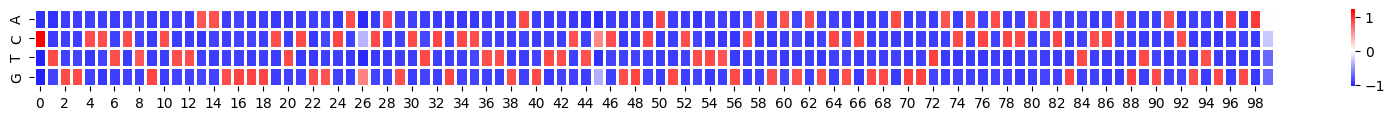

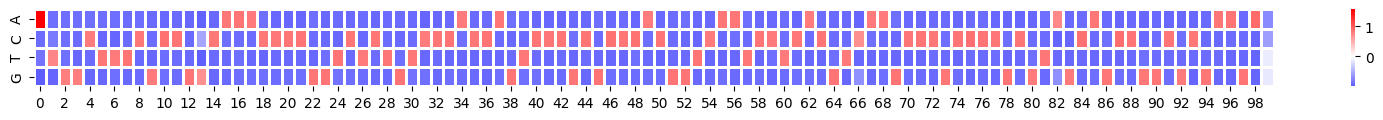

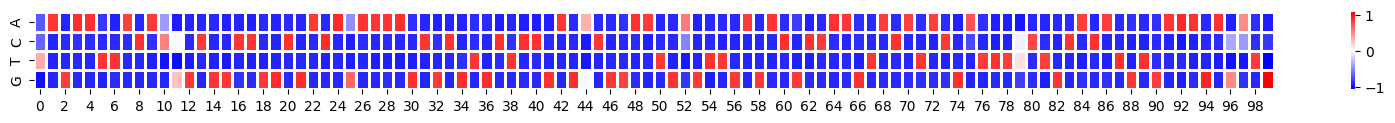

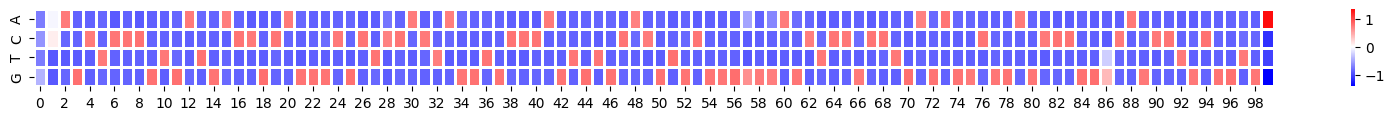

 Epoch 90 Train Loss: 0.08232738822698593 | Val Loss: 0.07449322925064682
 Epoch 91 Train Loss: 0.09527728706598282 | Val Loss: 0.07428600823829982
 Epoch 92 Train Loss: 0.1316145658493042 | Val Loss: 0.07078793828090853
 Epoch 93 Train Loss: 0.12402979284524918 | Val Loss: 0.07259140953360017
 Epoch 94 Train Loss: 0.037736207246780396 | Val Loss: 0.07323285797226035
 Epoch 95 Train Loss: 0.05776306986808777 | Val Loss: 0.07350604277689102
 Epoch 96 Train Loss: 0.07845306396484375 | Val Loss: 0.0667865996187445
 Epoch 97 Train Loss: 0.039805516600608826 | Val Loss: 0.0688945133362181
 Epoch 98 Train Loss: 0.09356266260147095 | Val Loss: 0.0685941291249488
 Epoch 99 Train Loss: 0.03238243982195854 | Val Loss: 0.06970455078792966
 Epoch 100 Train Loss: 0.10224801301956177 | Val Loss: 0.07126464344145468
 Epoch 101 Train Loss: 0.03503677248954773 | Val Loss: 0.06846785420659653
 Epoch 102 Train Loss: 0.13316667079925537 | Val Loss: 0.07243463719525367
 Epoch 103 Train Loss: 0.084141194820

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

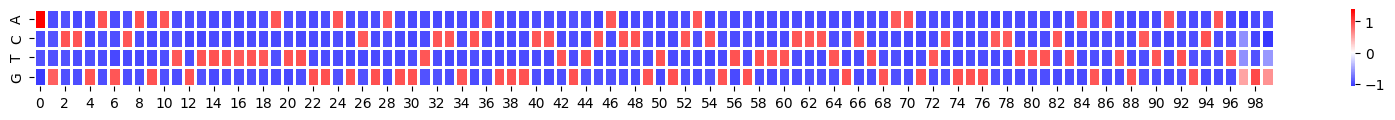

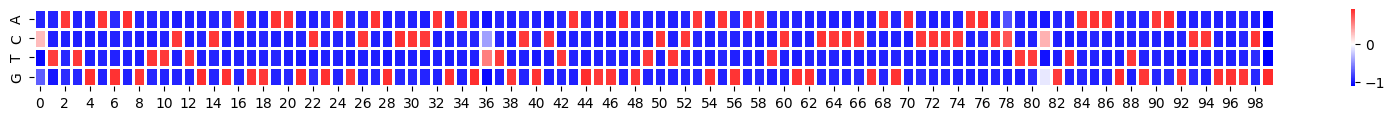

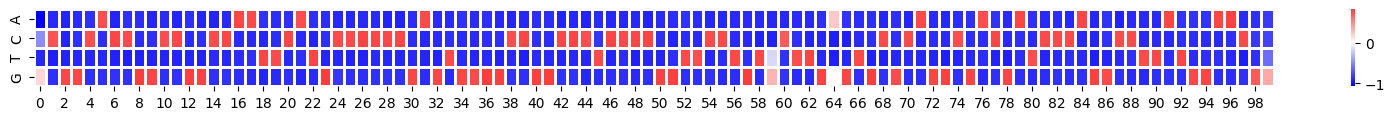

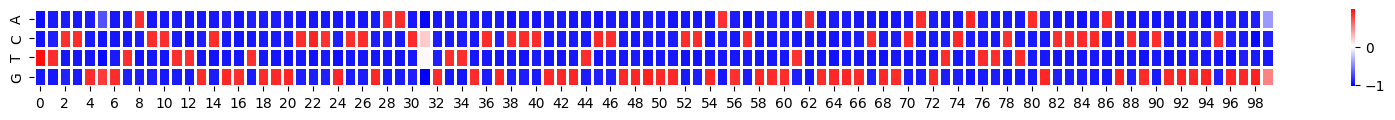

 Epoch 120 Train Loss: 0.10498221963644028 | Val Loss: 0.06782076520121787
 Epoch 121 Train Loss: 0.059376273304224014 | Val Loss: 0.07256782832286082
 Epoch 122 Train Loss: 0.09197977930307388 | Val Loss: 0.06800075686221158
 Epoch 123 Train Loss: 0.08178099244832993 | Val Loss: 0.07228368619256768
 Epoch 124 Train Loss: 0.059339284896850586 | Val Loss: 0.07437674422586753
 Epoch 125 Train Loss: 0.015590375289320946 | Val Loss: 0.06974671401799279
 Epoch 126 Train Loss: 0.06530655920505524 | Val Loss: 0.07005931393913001
 Epoch 127 Train Loss: 0.1101645827293396 | Val Loss: 0.06845761447652313
 Epoch 128 Train Loss: 0.06815982609987259 | Val Loss: 0.07150844436846981
 Epoch 129 Train Loss: 0.0704859048128128 | Val Loss: 0.069089779784241
 Epoch 130 Train Loss: 0.0828537568449974 | Val Loss: 0.07352708072270736
 Epoch 131 Train Loss: 0.04740651696920395 | Val Loss: 0.07259345658061918
 Epoch 132 Train Loss: 0.050654660910367966 | Val Loss: 0.0684584464939419
 Epoch 133 Train Loss: 0.05

In [ ]:
model1, optimizer, dataloader = accelerator.prepare(model1, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model1).eval().requires_grad_(False)
train_loss_values1 = []
val_loss_values1 = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model1.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model1):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model1, x, t, y, loss_type="l2")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model1)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model1.parameters(), max_norm=0.2
        )

    # Validation loop
    model1.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model1, val_x, val_t, val_y, loss_type="l2").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model1, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values1.append(train_loss.item())
    val_loss_values1.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

In [ ]:
val_loss_values1

[0.35029621877946143,
 0.26809011122658233,
 0.23500930859653418,
 0.21987501134680323,
 0.21847696768597138,
 0.20916146834280866,
 0.20098623239304408,
 0.19046317314929215,
 0.1816163857367413,
 0.1831045263747046,
 0.1671462206801107,
 0.15606795719339828,
 0.15825017049046589,
 0.14887578517568012,
 0.1430731231639208,
 0.1390535171059045,
 0.13391848314892163,
 0.12899335761639205,
 0.12861660849456943,
 0.13146473011694665,
 0.12266172536394813,
 0.12317070772886769,
 0.1213843335882445,
 0.11087804533972227,
 0.10687907692814662,
 0.1082320616634424,
 0.1074875150152967,
 0.10168151754485674,
 0.10139726108509647,
 0.09643217702665605,
 0.09695394715863812,
 0.0928147405324396,
 0.0949432446259605,
 0.09272298543167508,
 0.09455008712435557,
 0.08797572106738721,
 0.09254039405298627,
 0.08845179681935586,
 0.09017710524711235,
 0.08823544550533137,
 0.08881522879804954,
 0.08687365658519682,
 0.08764253864603594,
 0.08408658566676881,
 0.08104924041747062,
 0.08868753161927885

In [ ]:
model1 = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model1.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
optimizer = Adam(model1.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

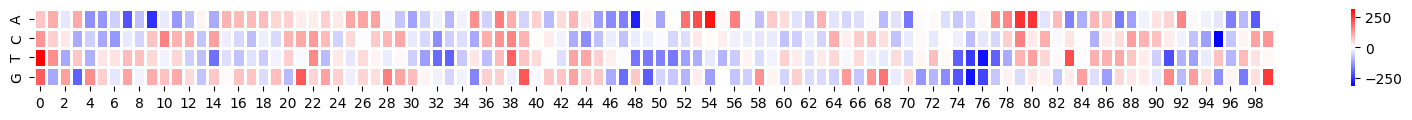

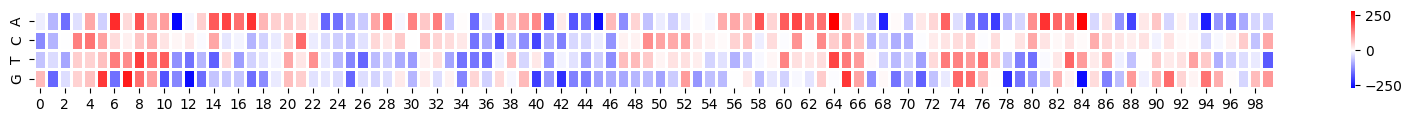

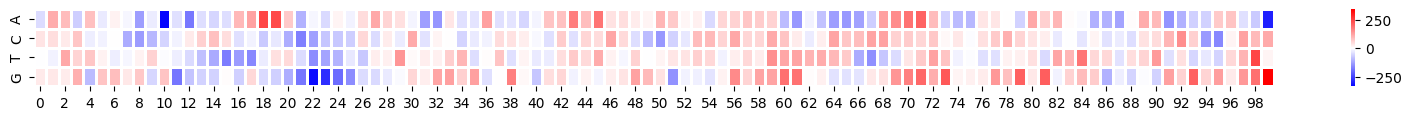

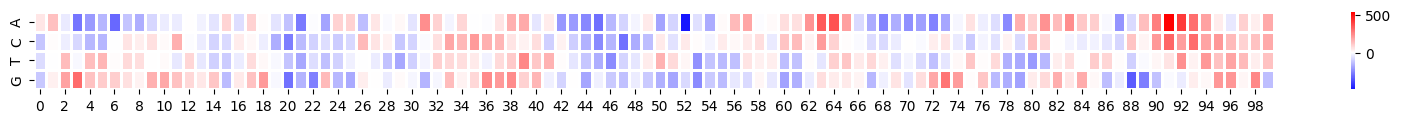

 Epoch 0 Train Loss: 0.1838458925485611 | Val Loss: 0.1711313077364086
 Epoch 1 Train Loss: 0.15230098366737366 | Val Loss: 0.12253799524989502
 Epoch 2 Train Loss: 0.0835573673248291 | Val Loss: 0.1078339803748387
 Epoch 3 Train Loss: 0.09607952833175659 | Val Loss: 0.10278310067951679
 Epoch 4 Train Loss: 0.07823256403207779 | Val Loss: 0.10223288781756212
 Epoch 5 Train Loss: 0.12507258355617523 | Val Loss: 0.09830622615154125
 Epoch 6 Train Loss: 0.025296716019511223 | Val Loss: 0.09469117742986226
 Epoch 7 Train Loss: 0.08113359659910202 | Val Loss: 0.0886063883311985
 Epoch 8 Train Loss: 0.04915507510304451 | Val Loss: 0.08487314401456147
 Epoch 9 Train Loss: 0.11231130361557007 | Val Loss: 0.08431430873730458
 Epoch 10 Train Loss: 0.09213638305664062 | Val Loss: 0.07730108287093068
 Epoch 11 Train Loss: 0.06366004794836044 | Val Loss: 0.07226724037515724
 Epoch 12 Train Loss: 0.13772273063659668 | Val Loss: 0.07331498375177876
 Epoch 13 Train Loss: 0.048274021595716476 | Val Los

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

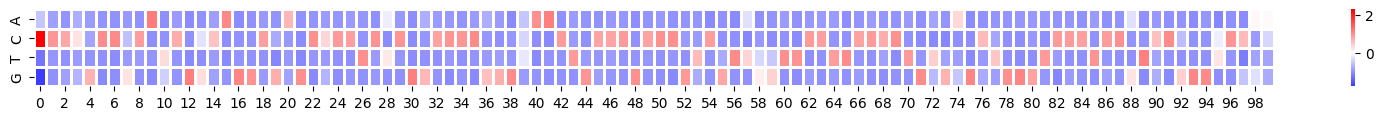

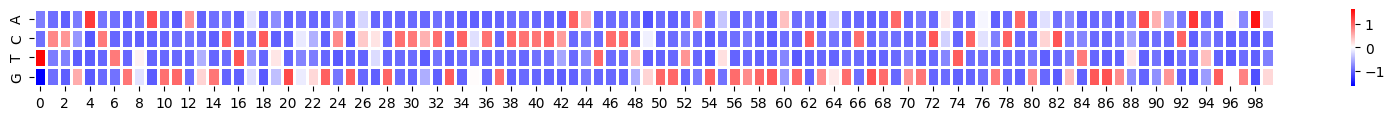

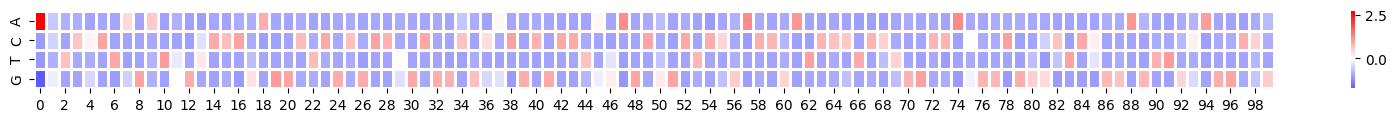

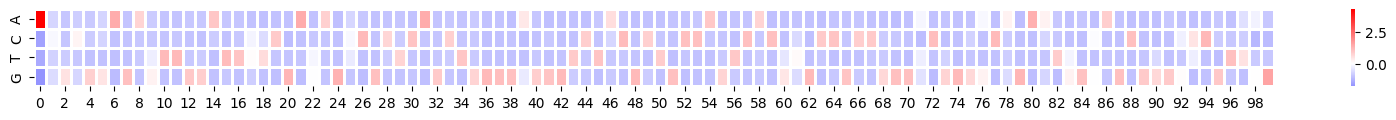

 Epoch 30 Train Loss: 0.04276934266090393 | Val Loss: 0.04714842076020793
 Epoch 31 Train Loss: 0.03903886675834656 | Val Loss: 0.04499821354103975
 Epoch 32 Train Loss: 0.07497534155845642 | Val Loss: 0.04418381810003568
 Epoch 33 Train Loss: 0.025705324485898018 | Val Loss: 0.04398846809467501
 Epoch 34 Train Loss: 0.03922949731349945 | Val Loss: 0.044309049550336134
 Epoch 35 Train Loss: 0.037323739379644394 | Val Loss: 0.04114781659527505
 Epoch 36 Train Loss: 0.042170505970716476 | Val Loss: 0.04413697542237841
 Epoch 37 Train Loss: 0.0438244491815567 | Val Loss: 0.042218564971049956
 Epoch 38 Train Loss: 0.058368582278490067 | Val Loss: 0.042108488723266224
 Epoch 39 Train Loss: 0.029375549405813217 | Val Loss: 0.04150646923433158
 Epoch 40 Train Loss: 0.07197317481040955 | Val Loss: 0.04173290102226921
 Epoch 41 Train Loss: 0.03135623410344124 | Val Loss: 0.041265703722341986
 Epoch 42 Train Loss: 0.022413082420825958 | Val Loss: 0.04148656948785151
 Epoch 43 Train Loss: 0.04205

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

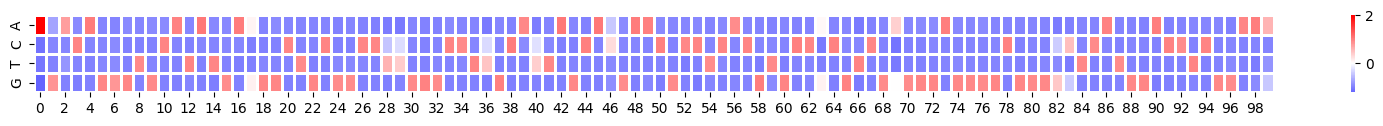

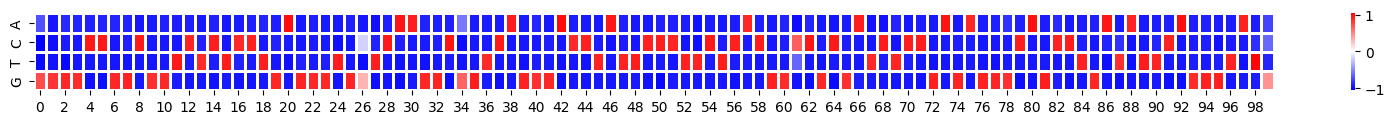

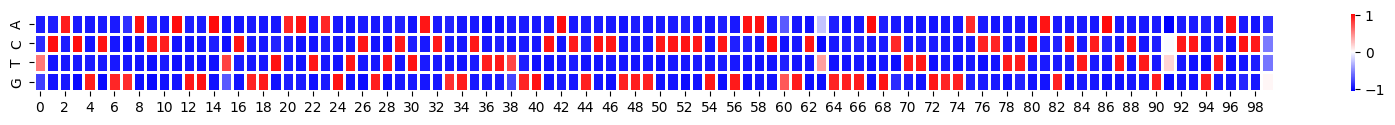

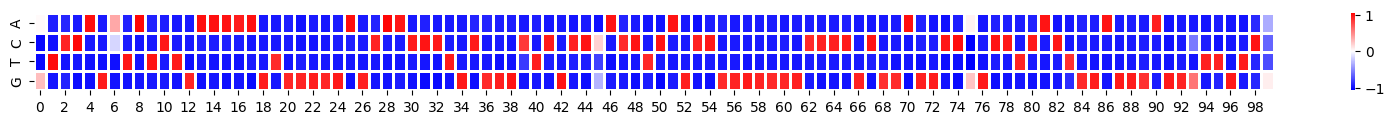

 Epoch 60 Train Loss: 0.029081106185913086 | Val Loss: 0.03573621821797584
 Epoch 61 Train Loss: 0.029968837276101112 | Val Loss: 0.035821195545583225
 Epoch 62 Train Loss: 0.032511141151189804 | Val Loss: 0.034448151022565265
 Epoch 63 Train Loss: 0.023316912353038788 | Val Loss: 0.03472213677615543
 Epoch 64 Train Loss: 0.03828461840748787 | Val Loss: 0.036514445415828836
 Epoch 65 Train Loss: 0.04451969638466835 | Val Loss: 0.03452427756841764
 Epoch 66 Train Loss: 0.022267017513513565 | Val Loss: 0.03692911449850591
 Epoch 67 Train Loss: 0.038194794207811356 | Val Loss: 0.03441286914450817
 Epoch 68 Train Loss: 0.04367562010884285 | Val Loss: 0.04067061434322891
 Epoch 69 Train Loss: 0.02167806588113308 | Val Loss: 0.03738774984212946
 Epoch 70 Train Loss: 0.039539217948913574 | Val Loss: 0.03598032473809709
 Epoch 71 Train Loss: 0.03477432578802109 | Val Loss: 0.036238898630908206
 Epoch 72 Train Loss: 0.04889915511012077 | Val Loss: 0.03633604922970711
 Epoch 73 Train Loss: 0.046

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

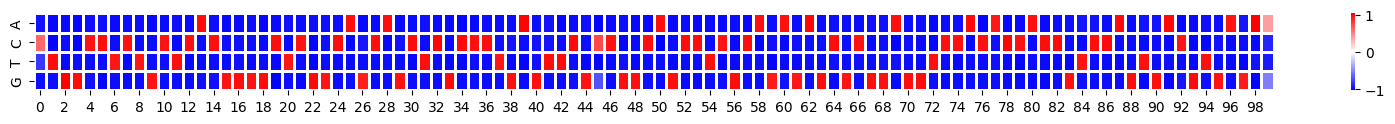

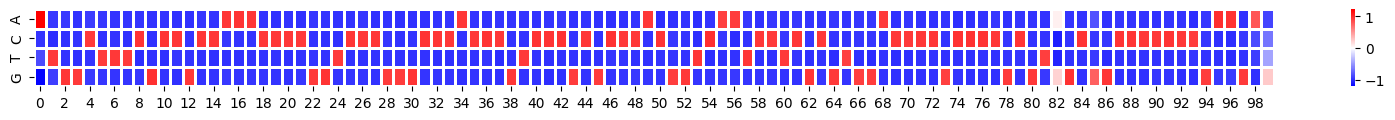

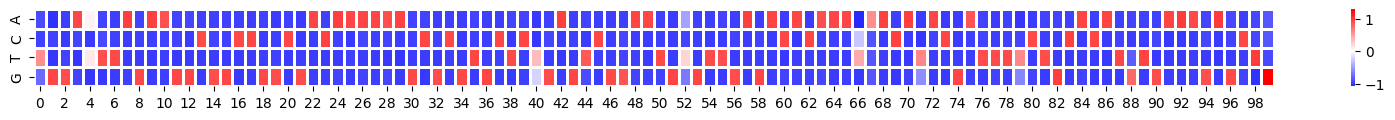

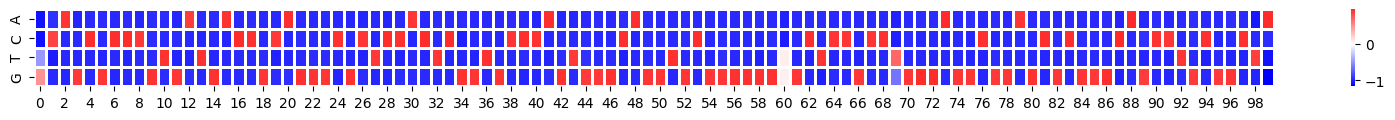

 Epoch 90 Train Loss: 0.028731700032949448 | Val Loss: 0.03318736147258646
 Epoch 91 Train Loss: 0.04584674909710884 | Val Loss: 0.03366885812999296
 Epoch 92 Train Loss: 0.03992866724729538 | Val Loss: 0.03362939850819751
 Epoch 93 Train Loss: 0.03466908633708954 | Val Loss: 0.03351022767226312
 Epoch 94 Train Loss: 0.025489022955298424 | Val Loss: 0.0333498939871788
 Epoch 95 Train Loss: 0.024622634053230286 | Val Loss: 0.03386363793503155
 Epoch 96 Train Loss: 0.026831218972802162 | Val Loss: 0.030719271722472897
 Epoch 97 Train Loss: 0.022189931944012642 | Val Loss: 0.032048086062350795
 Epoch 98 Train Loss: 0.04042154923081398 | Val Loss: 0.031389173258804096
 Epoch 99 Train Loss: 0.027071472257375717 | Val Loss: 0.032255563076801046
 Epoch 100 Train Loss: 0.014760386198759079 | Val Loss: 0.033347992599780156
 Epoch 101 Train Loss: 0.06654174625873566 | Val Loss: 0.03158484572498513
 Epoch 102 Train Loss: 0.03785831481218338 | Val Loss: 0.033664052136057665
 Epoch 103 Train Loss: 

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

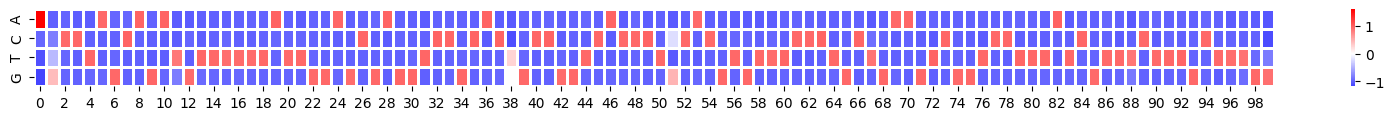

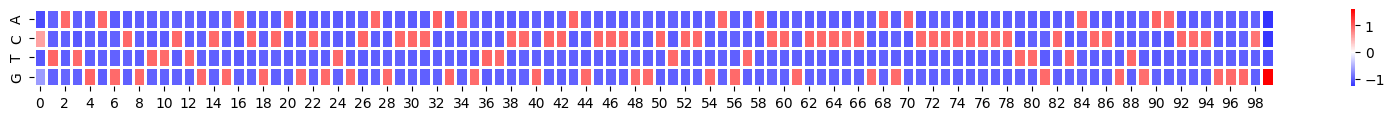

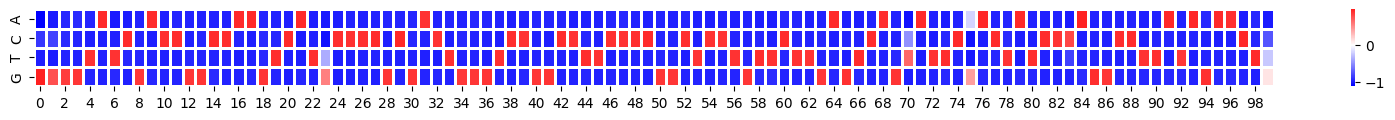

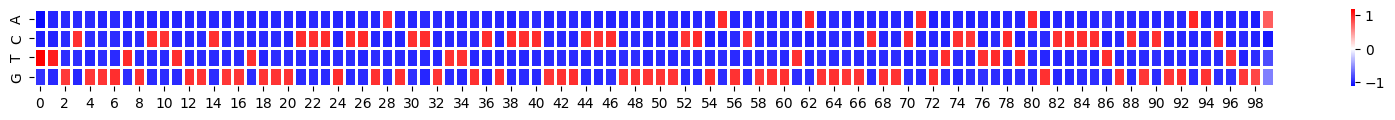

 Epoch 120 Train Loss: 0.04434041678905487 | Val Loss: 0.03126281946281756
 Epoch 121 Train Loss: 0.0236534271389246 | Val Loss: 0.032817579013072265
 Epoch 122 Train Loss: 0.016970030963420868 | Val Loss: 0.03139891032868427
 Epoch 123 Train Loss: 0.01617913693189621 | Val Loss: 0.03399796900147003
 Epoch 124 Train Loss: 0.03206561133265495 | Val Loss: 0.03371703608561892
 Epoch 125 Train Loss: 0.04136098921298981 | Val Loss: 0.03298918800890323
 Epoch 126 Train Loss: 0.02596871554851532 | Val Loss: 0.032512836266031936
 Epoch 127 Train Loss: 0.042879652231931686 | Val Loss: 0.032661514222036954
 Epoch 128 Train Loss: 0.02587449923157692 | Val Loss: 0.031921094258446706
 Epoch 129 Train Loss: 0.03284243494272232 | Val Loss: 0.03363895988907696
 Epoch 130 Train Loss: 0.031632039695978165 | Val Loss: 0.034350028792627094
 Epoch 131 Train Loss: 0.025696197524666786 | Val Loss: 0.03383504252973174
 Epoch 132 Train Loss: 0.024798773229122162 | Val Loss: 0.03222103962628556
 Epoch 133 Train

In [ ]:
model1, optimizer, dataloader = accelerator.prepare(model1, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model1).eval().requires_grad_(False)
train_loss_values1 = []
val_loss_values1 = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model1.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model1):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model1, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model1)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model1.parameters(), max_norm=0.2
        )

    # Validation loop
    model1.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model1, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model1, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values1.append(train_loss.item())
    val_loss_values1.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

In [ ]:
val_loss_values1

[0.1711313077364086,
 0.12253799524989502,
 0.1078339803748387,
 0.10278310067951679,
 0.10223288781756212,
 0.09830622615154125,
 0.09469117742986226,
 0.0886063883311985,
 0.08487314401456147,
 0.08431430873730458,
 0.07730108287093068,
 0.07226724037515724,
 0.07331498375177876,
 0.06813792522596426,
 0.06482766750307123,
 0.06319290153251207,
 0.060757767193573564,
 0.05953968288607834,
 0.059777781382695704,
 0.06033793385794833,
 0.05716083945383218,
 0.05813879056348781,
 0.057549601820997956,
 0.05296956658486492,
 0.05193047912037077,
 0.05297710224678201,
 0.053189786612864366,
 0.05103658236686356,
 0.049955251772911095,
 0.047117172701915434,
 0.04714842076020793,
 0.04499821354103975,
 0.04418381810003568,
 0.04398846809467501,
 0.044309049550336134,
 0.04114781659527505,
 0.04413697542237841,
 0.042218564971049956,
 0.042108488723266224,
 0.04150646923433158,
 0.04173290102226921,
 0.041265703722341986,
 0.04148656948785151,
 0.03971879211954834,
 0.03797210183394842,
 0.

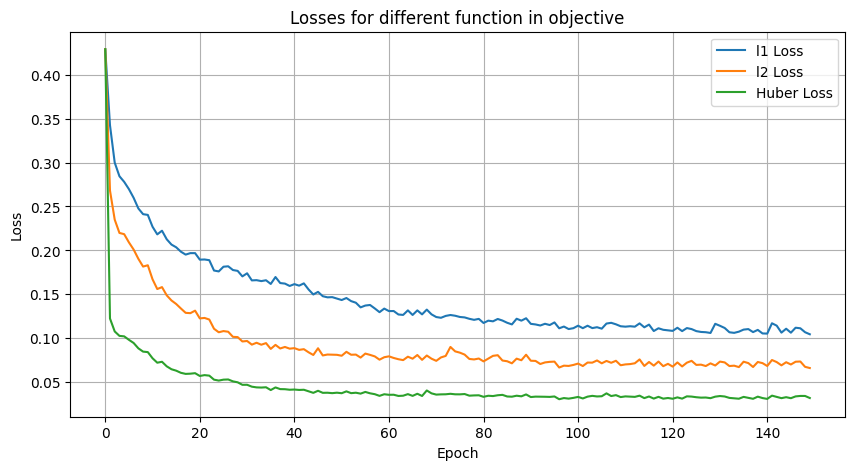

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(range(len(loss_values_optimizer1)), loss_values_optimizer1, label='l1 Loss')
plt.plot(range(len(loss_values_optimizer2)), loss_values_optimizer2, label='l2 Loss')
plt.plot(range(len(loss_values_optimizer3)), loss_values_optimizer3, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses for different function in objective')
plt.grid(True)
plt.legend()
plt.show()

# Optimizers

In [ ]:
model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

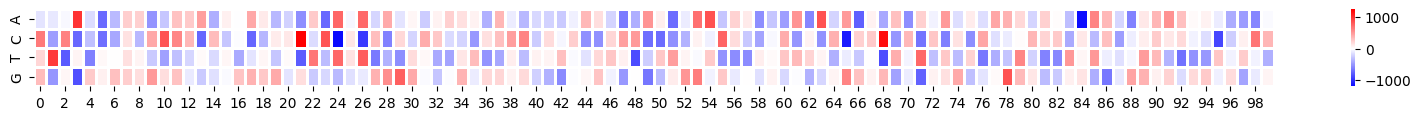

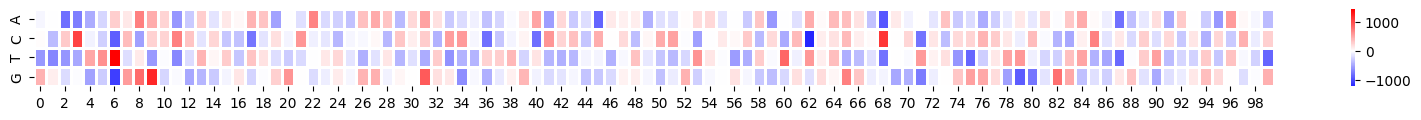

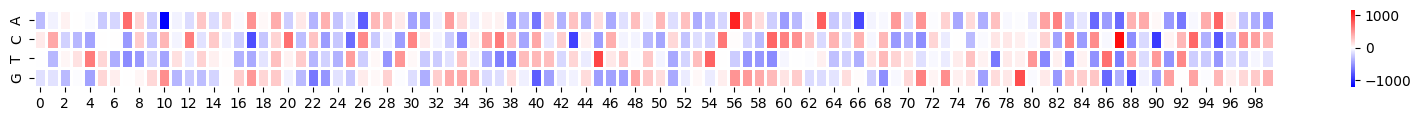

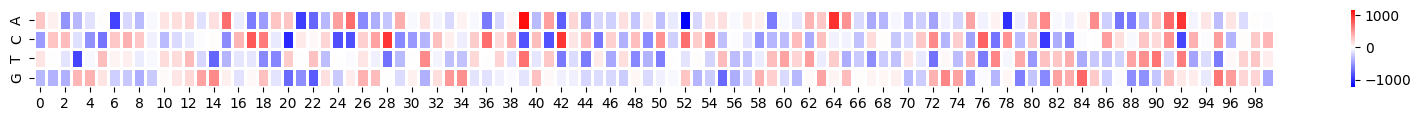

 Epoch 0 Train Loss: 0.7727401256561279 | Val Loss: 0.77091708754705
 Epoch 1 Train Loss: 0.7199820876121521 | Val Loss: 0.7053770890905837
 Epoch 2 Train Loss: 0.58296799659729 | Val Loss: 0.6053907861394331
 Epoch 3 Train Loss: 0.4883948266506195 | Val Loss: 0.4867921914936097
 Epoch 4 Train Loss: 0.3791728913784027 | Val Loss: 0.42528711148529996
 Epoch 5 Train Loss: 0.43880924582481384 | Val Loss: 0.39329720183837513
 Epoch 6 Train Loss: 0.23247745633125305 | Val Loss: 0.3672529736087342
 Epoch 7 Train Loss: 0.3309426009654999 | Val Loss: 0.3412552810897512
 Epoch 8 Train Loss: 0.24214060604572296 | Val Loss: 0.327867740441945
 Epoch 9 Train Loss: 0.3691624701023102 | Val Loss: 0.3243167442231139
 Epoch 10 Train Loss: 0.34248825907707214 | Val Loss: 0.30650249591543655
 Epoch 11 Train Loss: 0.2666756212711334 | Val Loss: 0.2993111671987644
 Epoch 12 Train Loss: 0.4840189814567566 | Val Loss: 0.30562888578442504
 Epoch 13 Train Loss: 0.24471688270568848 | Val Loss: 0.295743285501298

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

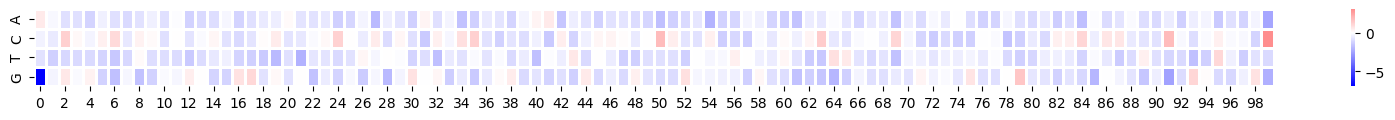

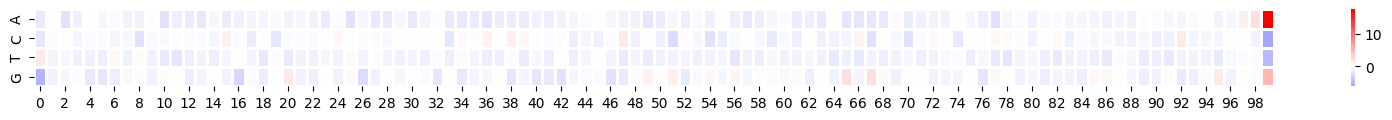

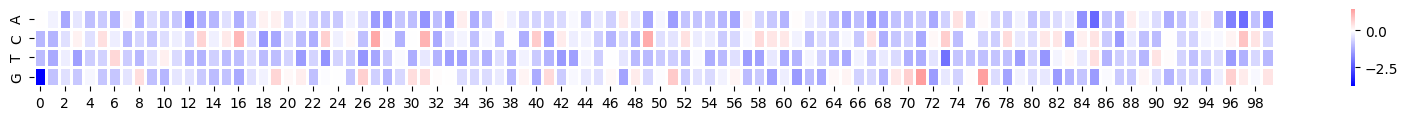

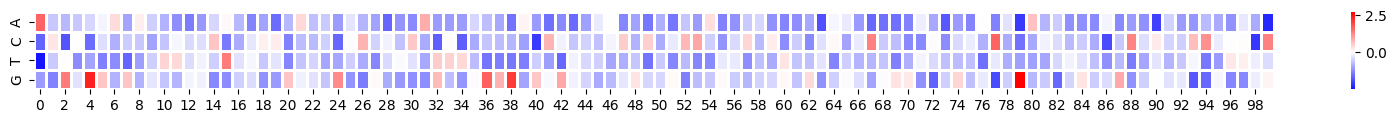

 Epoch 30 Train Loss: 0.336698442697525 | Val Loss: 0.27972009445517515
 Epoch 31 Train Loss: 0.3496776521205902 | Val Loss: 0.26200487624761487
 Epoch 32 Train Loss: 0.40751466155052185 | Val Loss: 0.26491180086924027
 Epoch 33 Train Loss: 0.2006438970565796 | Val Loss: 0.26059458250841816
 Epoch 34 Train Loss: 0.24005110561847687 | Val Loss: 0.2647708987524687
 Epoch 35 Train Loss: 0.29545608162879944 | Val Loss: 0.2629339013956795
 Epoch 36 Train Loss: 0.3360498249530792 | Val Loss: 0.27461978140448734
 Epoch 37 Train Loss: 0.23777294158935547 | Val Loss: 0.26588671377375106
 Epoch 38 Train Loss: 0.3245369493961334 | Val Loss: 0.25806958788682605
 Epoch 39 Train Loss: 0.2659265100955963 | Val Loss: 0.25498099809835767
 Epoch 40 Train Loss: 0.3083689212799072 | Val Loss: 0.26364851761455377
 Epoch 41 Train Loss: 0.3087421953678131 | Val Loss: 0.26220903053017686
 Epoch 42 Train Loss: 0.15286758542060852 | Val Loss: 0.26970972496369655
 Epoch 43 Train Loss: 0.23559197783470154 | Val L

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

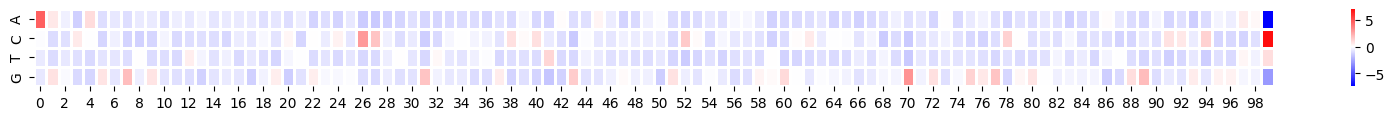

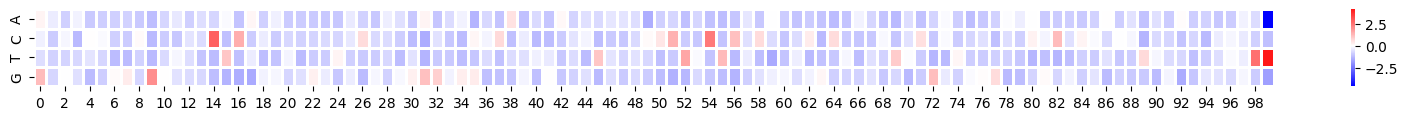

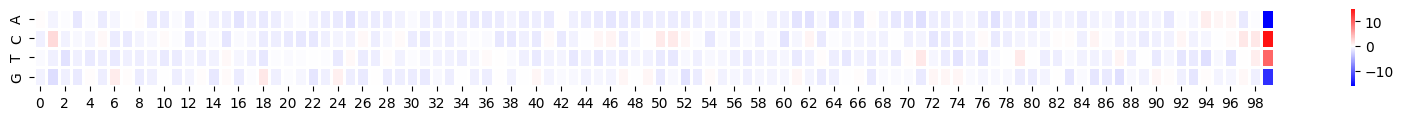

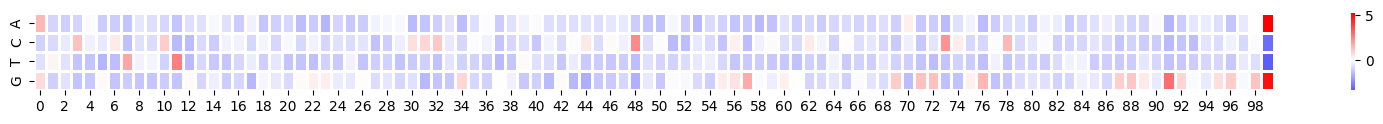

 Epoch 60 Train Loss: 0.15151427686214447 | Val Loss: 0.22365848535348562
 Epoch 61 Train Loss: 0.22805054485797882 | Val Loss: 0.22060198798652522
 Epoch 62 Train Loss: 0.24372372031211853 | Val Loss: 0.21696303550862084
 Epoch 63 Train Loss: 0.20678091049194336 | Val Loss: 0.22013429675466759
 Epoch 64 Train Loss: 0.2549905776977539 | Val Loss: 0.21951204119635023
 Epoch 65 Train Loss: 0.19335460662841797 | Val Loss: 0.21382355856255067
 Epoch 66 Train Loss: 0.15753383934497833 | Val Loss: 0.21835410225489907
 Epoch 67 Train Loss: 0.25127801299095154 | Val Loss: 0.21002078659770904
 Epoch 68 Train Loss: 0.263672411441803 | Val Loss: 0.21901344908170464
 Epoch 69 Train Loss: 0.16707074642181396 | Val Loss: 0.2085322055442274
 Epoch 70 Train Loss: 0.2662743031978607 | Val Loss: 0.20196445076918798
 Epoch 71 Train Loss: 0.21802663803100586 | Val Loss: 0.2028809941012012
 Epoch 72 Train Loss: 0.23194344341754913 | Val Loss: 0.211013392599161
 Epoch 73 Train Loss: 0.16944347321987152 | Va

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

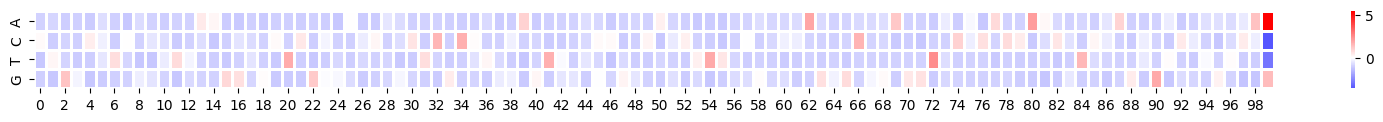

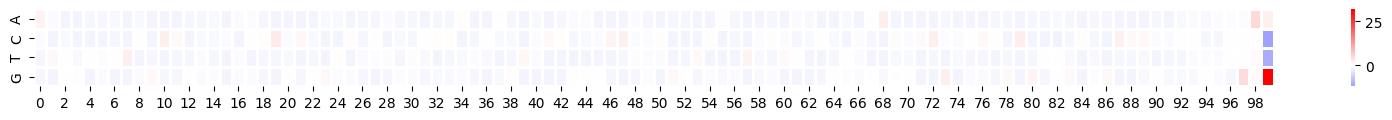

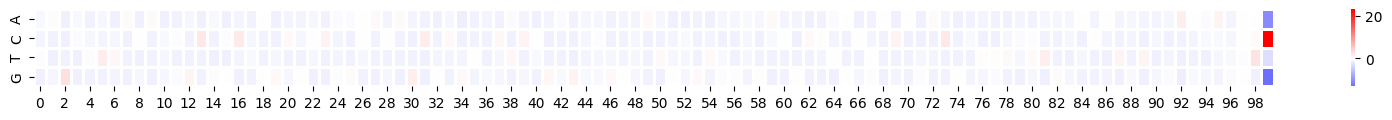

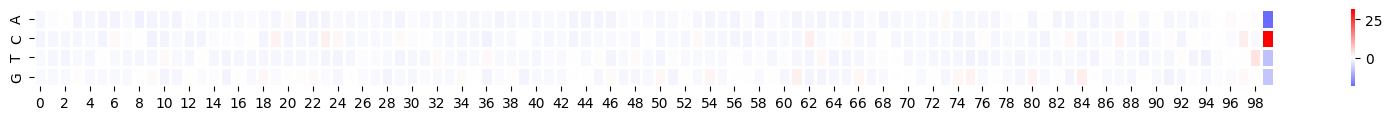

 Epoch 90 Train Loss: 0.16972000896930695 | Val Loss: 0.19008043710111586
 Epoch 91 Train Loss: 0.1476011425256729 | Val Loss: 0.18921710809400258
 Epoch 92 Train Loss: 0.17884373664855957 | Val Loss: 0.18660742580151754
 Epoch 93 Train Loss: 0.2892366051673889 | Val Loss: 0.19002620352447525
 Epoch 94 Train Loss: 0.22630485892295837 | Val Loss: 0.18722658973833747
 Epoch 95 Train Loss: 0.18228046596050262 | Val Loss: 0.18539234244626415
 Epoch 96 Train Loss: 0.14548814296722412 | Val Loss: 0.1798112747713554
 Epoch 97 Train Loss: 0.1837458461523056 | Val Loss: 0.18060334223853655
 Epoch 98 Train Loss: 0.31747835874557495 | Val Loss: 0.1799077533247057
 Epoch 99 Train Loss: 0.16443316638469696 | Val Loss: 0.18102610850137127
 Epoch 100 Train Loss: 0.12734979391098022 | Val Loss: 0.18606301452502733
 Epoch 101 Train Loss: 0.22655418515205383 | Val Loss: 0.18265983043623366
 Epoch 102 Train Loss: 0.13696932792663574 | Val Loss: 0.1863493431082442
 Epoch 103 Train Loss: 0.1418519020080566

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

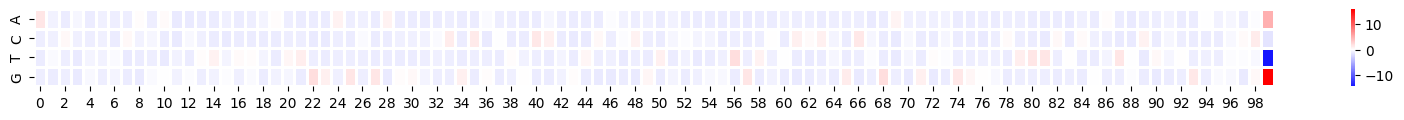

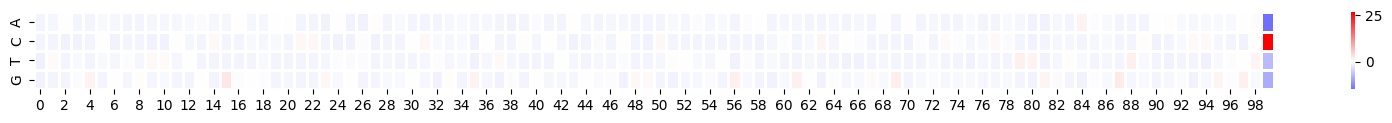

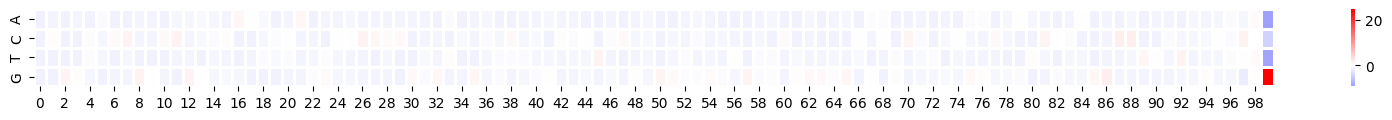

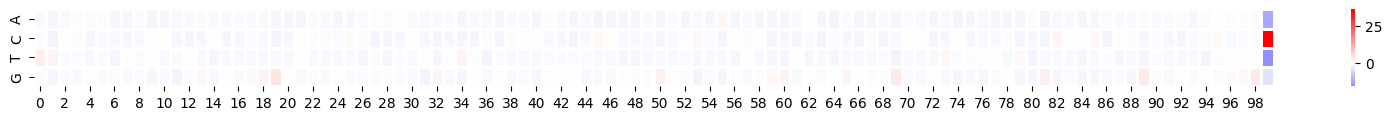

 Epoch 120 Train Loss: 0.2206648588180542 | Val Loss: 0.17461493814533408
 Epoch 121 Train Loss: 0.146703839302063 | Val Loss: 0.17807478002033944
 Epoch 122 Train Loss: 0.11161202192306519 | Val Loss: 0.17327019387532858
 Epoch 123 Train Loss: 0.17233900725841522 | Val Loss: 0.17728410402605357
 Epoch 124 Train Loss: 0.19806551933288574 | Val Loss: 0.17820236961211056
 Epoch 125 Train Loss: 0.1716088503599167 | Val Loss: 0.17808149453283342
 Epoch 126 Train Loss: 0.16836632788181305 | Val Loss: 0.17473846212152608
 Epoch 127 Train Loss: 0.16460244357585907 | Val Loss: 0.17346943416132415
 Epoch 128 Train Loss: 0.18138602375984192 | Val Loss: 0.17449003063942775
 Epoch 129 Train Loss: 0.13880804181098938 | Val Loss: 0.17187763645875553
 Epoch 130 Train Loss: 0.13365991413593292 | Val Loss: 0.1788561374318501
 Epoch 131 Train Loss: 0.14732660353183746 | Val Loss: 0.18025327652446493
 Epoch 132 Train Loss: 0.1222028136253357 | Val Loss: 0.1718324037376514
 Epoch 133 Train Loss: 0.1839474

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="l1")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="l1").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

In [ ]:
val_loss_values

[0.77091708754705,
 0.7053770890905837,
 0.6053907861394331,
 0.4867921914936097,
 0.42528711148529996,
 0.39329720183837513,
 0.3672529736087342,
 0.3412552810897512,
 0.327867740441945,
 0.3243167442231139,
 0.30650249591543655,
 0.2993111671987644,
 0.30562888578442504,
 0.2957432855012988,
 0.29182010445713014,
 0.28874404217339744,
 0.2882761409706321,
 0.28350285717771073,
 0.28947617212110316,
 0.29164696207716445,
 0.28516172636146386,
 0.2873238036947802,
 0.28556154200360795,
 0.27317875057212576,
 0.2758934399313178,
 0.27863391550365557,
 0.283754599242171,
 0.2773050593812604,
 0.2797534633273921,
 0.270368291573091,
 0.27972009445517515,
 0.26200487624761487,
 0.26491180086924027,
 0.26059458250841816,
 0.2647708987524687,
 0.2629339013956795,
 0.27461978140448734,
 0.26588671377375106,
 0.25806958788682605,
 0.25498099809835767,
 0.26364851761455377,
 0.26220903053017686,
 0.26970972496369655,
 0.2514883247781391,
 0.2465293137741483,
 0.24962398372898417,
 0.24391551278

In [ ]:
model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

In [ ]:
optimizer = SophiaG(model.parameters(), lr=LEARNING_RATE, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

  0%|          | 0/150 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

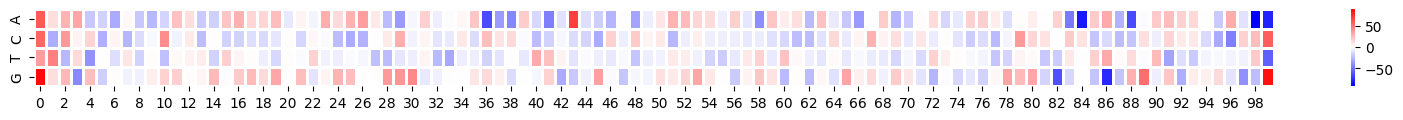

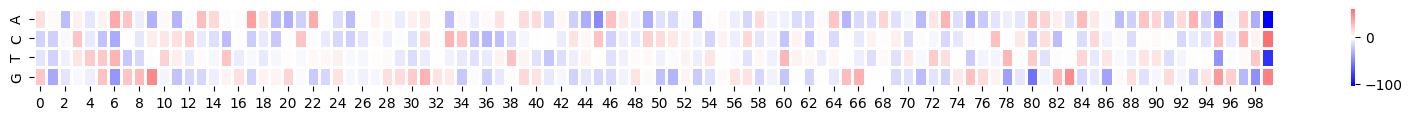

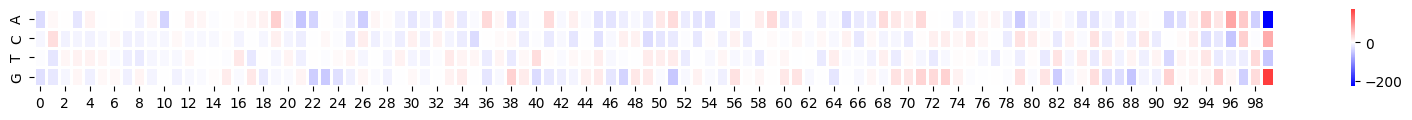

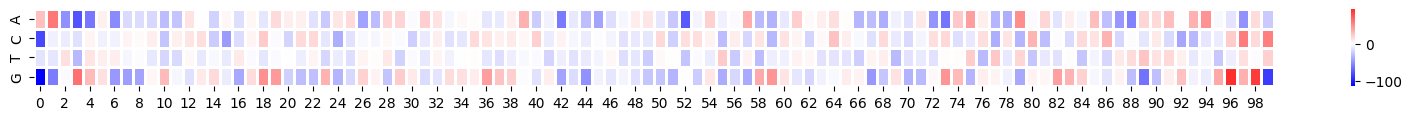

 Epoch 0 Train Loss: 0.3925761878490448 | Val Loss: 0.3673748125222104
 Epoch 1 Train Loss: 0.3397432863712311 | Val Loss: 0.2842207317633077
 Epoch 2 Train Loss: 0.22265605628490448 | Val Loss: 0.24420675044217385
 Epoch 3 Train Loss: 0.22349441051483154 | Val Loss: 0.22746333861646573
 Epoch 4 Train Loss: 0.1651580035686493 | Val Loss: 0.2176008785435976
 Epoch 5 Train Loss: 0.2385694980621338 | Val Loss: 0.2077086699649322
 Epoch 6 Train Loss: 0.09900268912315369 | Val Loss: 0.19975621832057464
 Epoch 7 Train Loss: 0.1832161396741867 | Val Loss: 0.1875528668569139
 Epoch 8 Train Loss: 0.13809239864349365 | Val Loss: 0.17897993424707206
 Epoch 9 Train Loss: 0.22390660643577576 | Val Loss: 0.17633033685447755
 Epoch 10 Train Loss: 0.19458402693271637 | Val Loss: 0.17180642701131255
 Epoch 11 Train Loss: 0.15036720037460327 | Val Loss: 0.15702358448554662
 Epoch 12 Train Loss: 0.22384265065193176 | Val Loss: 0.1545121408691091
 Epoch 13 Train Loss: 0.09881522506475449 | Val Loss: 0.146

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

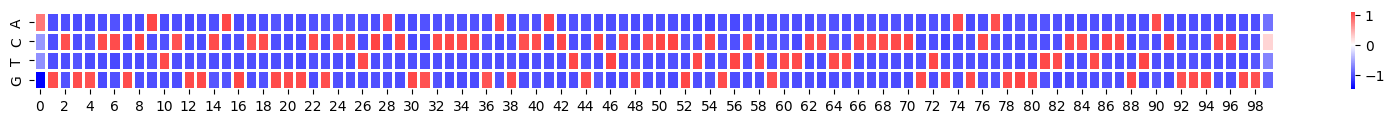

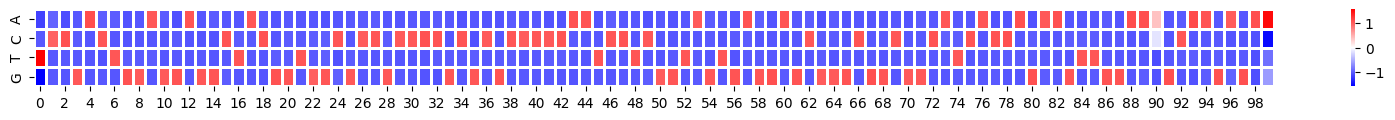

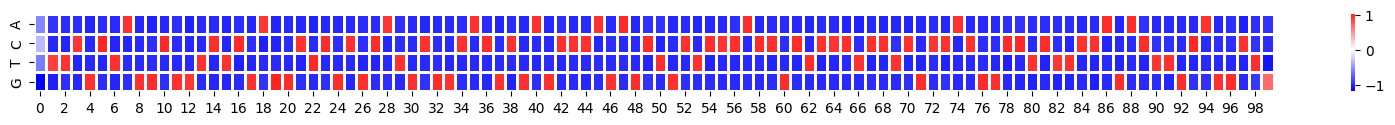

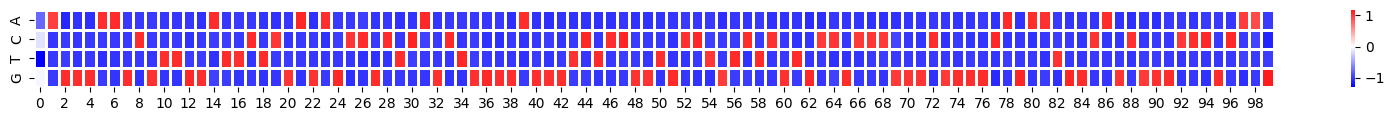

 Epoch 30 Train Loss: 0.10606204718351364 | Val Loss: 0.10733582916831182
 Epoch 31 Train Loss: 0.08703597635030746 | Val Loss: 0.10530767808398925
 Epoch 32 Train Loss: 0.15063908696174622 | Val Loss: 0.10890853238746154
 Epoch 33 Train Loss: 0.08470865339040756 | Val Loss: 0.11159954026095138
 Epoch 34 Train Loss: 0.10257849097251892 | Val Loss: 0.10969506741370544
 Epoch 35 Train Loss: 0.09031490981578827 | Val Loss: 0.10864810239184987
 Epoch 36 Train Loss: 0.0863787904381752 | Val Loss: 0.10676548291336406
 Epoch 37 Train Loss: 0.12540391087532043 | Val Loss: 0.10637112445205696
 Epoch 38 Train Loss: 0.11201690137386322 | Val Loss: 0.11389539729465138
 Epoch 39 Train Loss: 0.07398123294115067 | Val Loss: 0.11729737303473732
 Epoch 40 Train Loss: 0.1448340117931366 | Val Loss: 0.10673346176497207
 Epoch 41 Train Loss: 0.08105570822954178 | Val Loss: 0.10535615347017926
 Epoch 42 Train Loss: 0.07134131342172623 | Val Loss: 0.11074730803158657
 Epoch 43 Train Loss: 0.1246606782078743

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

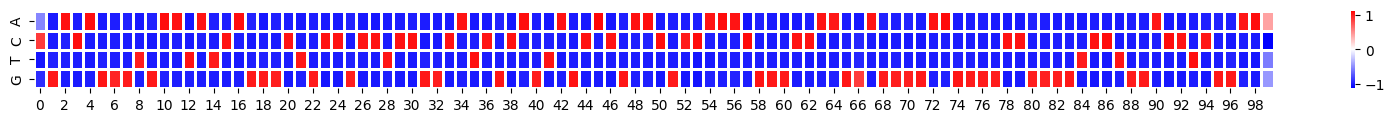

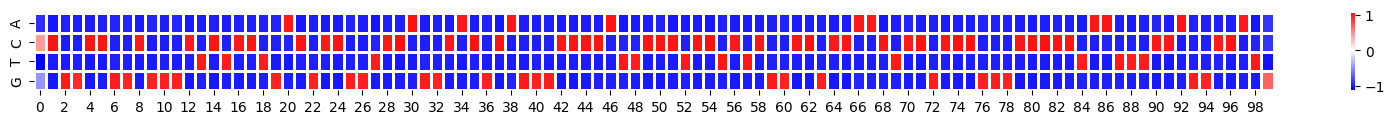

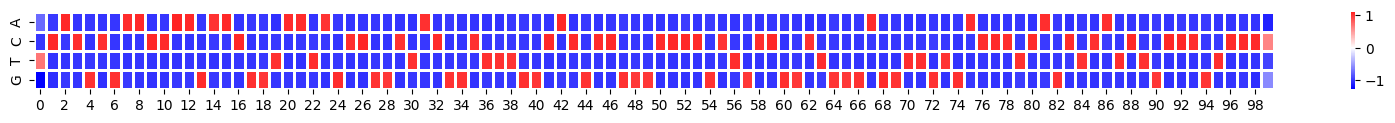

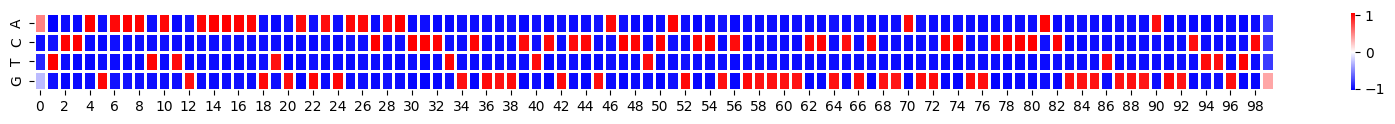

 Epoch 60 Train Loss: 0.09890413284301758 | Val Loss: 0.09634015287372692
 Epoch 61 Train Loss: 0.07840611040592194 | Val Loss: 0.09897563763516994
 Epoch 62 Train Loss: 0.086539126932621 | Val Loss: 0.09526832515666307
 Epoch 63 Train Loss: 0.06921963393688202 | Val Loss: 0.09454436070662885
 Epoch 64 Train Loss: 0.09117859601974487 | Val Loss: 0.09750160479471703
 Epoch 65 Train Loss: 0.10464925318956375 | Val Loss: 0.09611268969606762
 Epoch 66 Train Loss: 0.07332774251699448 | Val Loss: 0.10005064604203563
 Epoch 67 Train Loss: 0.10839425027370453 | Val Loss: 0.096367718636497
 Epoch 68 Train Loss: 0.11379024386405945 | Val Loss: 0.10052578412919991
 Epoch 69 Train Loss: 0.08190470188856125 | Val Loss: 0.10046644912155206
 Epoch 70 Train Loss: 0.11086438596248627 | Val Loss: 0.09937267350263831
 Epoch 71 Train Loss: 0.1190812811255455 | Val Loss: 0.09683427654884079
 Epoch 72 Train Loss: 0.1199335977435112 | Val Loss: 0.10013000934946635
 Epoch 73 Train Loss: 0.12276887893676758 | 

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

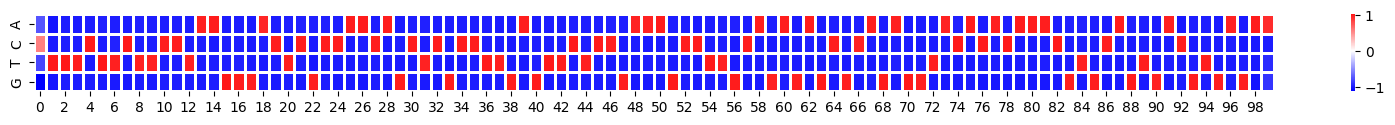

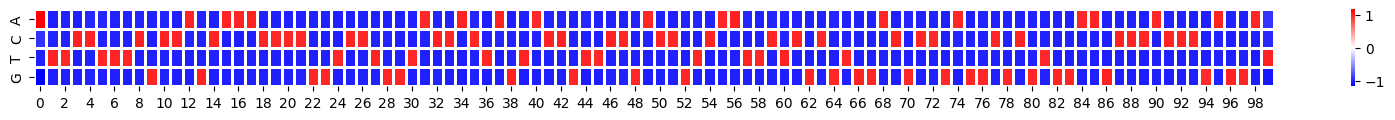

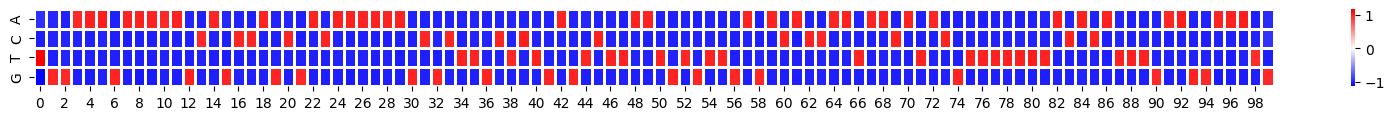

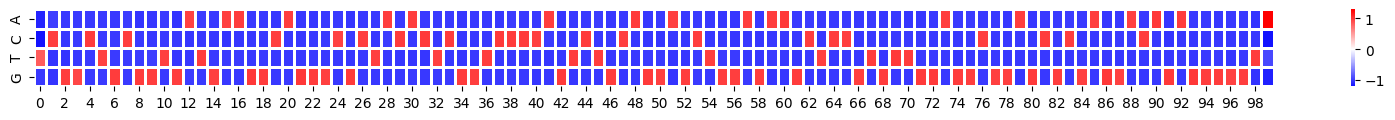

 Epoch 90 Train Loss: 0.08785049617290497 | Val Loss: 0.09215569751691227
 Epoch 91 Train Loss: 0.10230254381895065 | Val Loss: 0.09720034139954355
 Epoch 92 Train Loss: 0.0974060446023941 | Val Loss: 0.0929111980271241
 Epoch 93 Train Loss: 0.09624043852090836 | Val Loss: 0.09319806973303645
 Epoch 94 Train Loss: 0.08949127048254013 | Val Loss: 0.09547483259119278
 Epoch 95 Train Loss: 0.05514335259795189 | Val Loss: 0.09242241989728833
 Epoch 96 Train Loss: 0.1023801937699318 | Val Loss: 0.0893951521124229
 Epoch 97 Train Loss: 0.0643322691321373 | Val Loss: 0.09210348337088242
 Epoch 98 Train Loss: 0.11274249106645584 | Val Loss: 0.09107322867744225
 Epoch 99 Train Loss: 0.09745880216360092 | Val Loss: 0.08917595279857146
 Epoch 100 Train Loss: 0.06006572023034096 | Val Loss: 0.09422633713804
 Epoch 101 Train Loss: 0.15022511780261993 | Val Loss: 0.09310549368296774
 Epoch 102 Train Loss: 0.09722592681646347 | Val Loss: 0.09301445106706344
 Epoch 103 Train Loss: 0.07949508726596832 

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

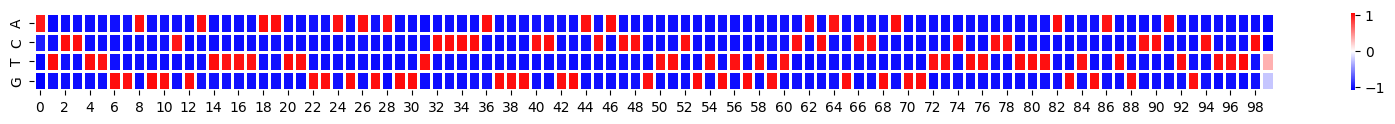

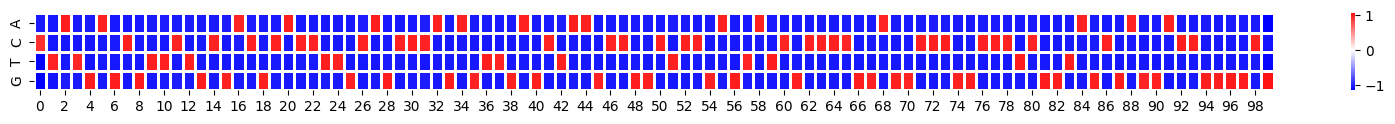

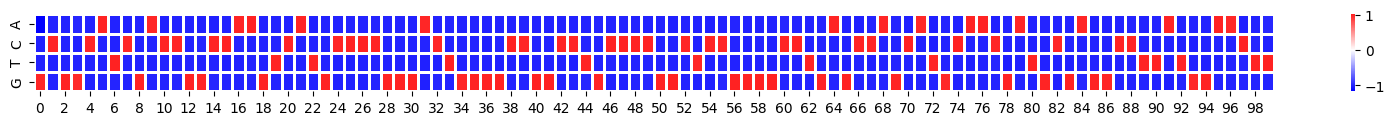

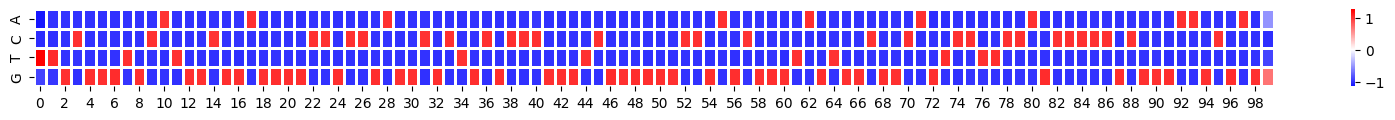

 Epoch 120 Train Loss: 0.10998839139938354 | Val Loss: 0.08828587805436662
 Epoch 121 Train Loss: 0.08020922541618347 | Val Loss: 0.0948242403197387
 Epoch 122 Train Loss: 0.0733836442232132 | Val Loss: 0.09181847029234752
 Epoch 123 Train Loss: 0.061475686728954315 | Val Loss: 0.09251367716380388
 Epoch 124 Train Loss: 0.11129806935787201 | Val Loss: 0.09274168352573371
 Epoch 125 Train Loss: 0.12260567396879196 | Val Loss: 0.09026771186550786
 Epoch 126 Train Loss: 0.07267625629901886 | Val Loss: 0.09329709435297438
 Epoch 127 Train Loss: 0.12698036432266235 | Val Loss: 0.09046578194853688
 Epoch 128 Train Loss: 0.08304993063211441 | Val Loss: 0.08809818450577003
 Epoch 129 Train Loss: 0.09650588035583496 | Val Loss: 0.09844551681856478
 Epoch 130 Train Loss: 0.09664241224527359 | Val Loss: 0.09651828110833799
 Epoch 131 Train Loss: 0.10399526357650757 | Val Loss: 0.09818635520733092
 Epoch 132 Train Loss: 0.07510661333799362 | Val Loss: 0.08844133287914528
 Epoch 133 Train Loss: 0.0

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(150)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="l1")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="l1").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

In [ ]:
val_loss_values

[0.3673748125222104,
 0.2842207317633077,
 0.24420675044217385,
 0.22746333861646573,
 0.2176008785435976,
 0.2077086699649322,
 0.19975621832057464,
 0.1875528668569139,
 0.17897993424707206,
 0.17633033685447755,
 0.17180642701131255,
 0.15702358448554662,
 0.1545121408691091,
 0.1465816058156904,
 0.1425210699931649,
 0.13741700542120894,
 0.12937998556154817,
 0.13079324475497253,
 0.13231897846726345,
 0.1292303754401601,
 0.12184122826688545,
 0.12769165154823586,
 0.1320352696559646,
 0.12006166060108783,
 0.11270760369202322,
 0.11883133071020616,
 0.11664215062768006,
 0.12040293309067891,
 0.11844710297574682,
 0.11075792218412249,
 0.10733582916831182,
 0.10530767808398925,
 0.10890853238746154,
 0.11159954026095138,
 0.10969506741370544,
 0.10864810239184987,
 0.10676548291336406,
 0.10637112445205696,
 0.11389539729465138,
 0.11729737303473732,
 0.10673346176497207,
 0.10535615347017926,
 0.11074730803158657,
 0.10695632987401703,
 0.09860540815621369,
 0.10427133227921714

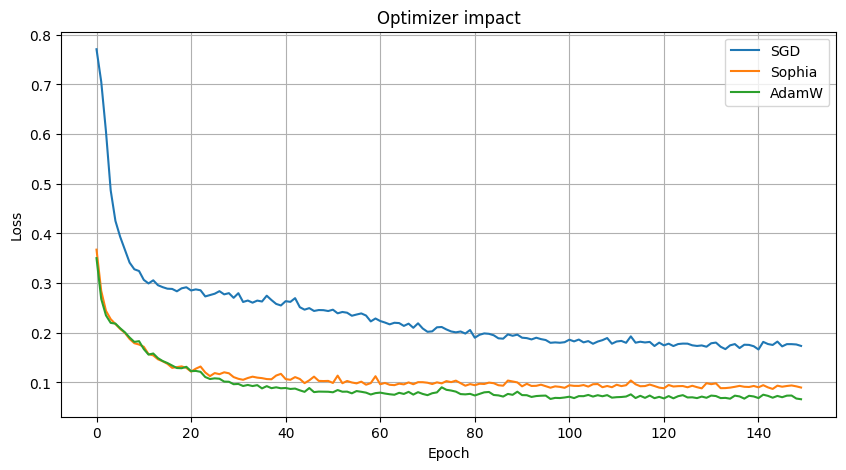

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(range(len(loss_values_optimizer1)), loss_values_optimizer1, label='SGD')
plt.plot(range(len(loss_values_optimizer2)), loss_values_optimizer2, label='Sophia')
plt.plot(range(len(loss_values_optimizer3)), loss_values_optimizer3, label='AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer impact')
plt.grid(True)
plt.legend()
plt.show()

# Curax


In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
      "/content/curax_filter-norm_to_500.fasta"
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[0])
raw_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 1})
raw_dataset.head()

chromosome                                       raw_sequence  \
0    chr1:5062183-5062695  TTCCAGCCAATCTATTGATTTAAACAATAGATCGTTTGAATCTATT...   
1    chr1:6907080-6907592  GGAGACGGAATCTTGCTCTATCTCCCAGGCTGGAGTGCAGTGGCGC...   
2    chr1:9165533-9166045  GGCAGACCTACATGCAGAACCACCAGCACCGGCGTCTGCACGGCCG...   
3    chr1:9167249-9167761  CCACCCACCTCCTCTCCAGAAGGAGAACAAAAACGTGAGCTCGAGC...   
4  chr1:14965703-14966215  AGCAGACAGAAGCCAGAGTGAGAAGGGGAGACCTCCCATTTGGACC...   

    type  label  
0  Z-DNA      1  
1  Z-DNA      1  
2  Z-DNA      1  
3  Z-DNA      1  
4  Z-DNA      1

In [ ]:
PATH = "diff_zdna_100.pth"

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=400, out_features=200, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

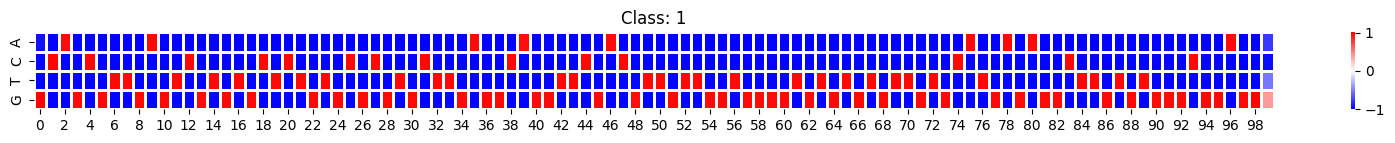

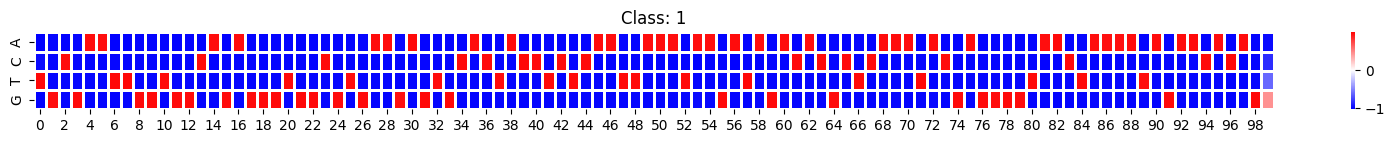

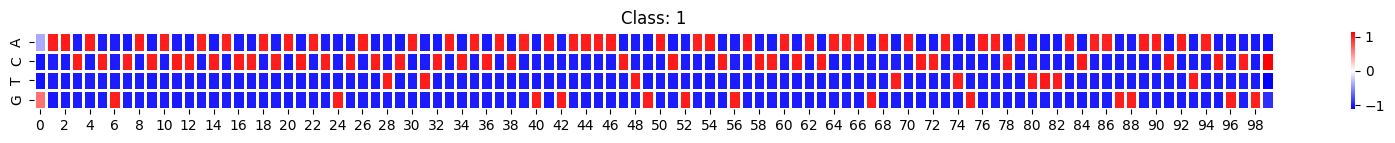

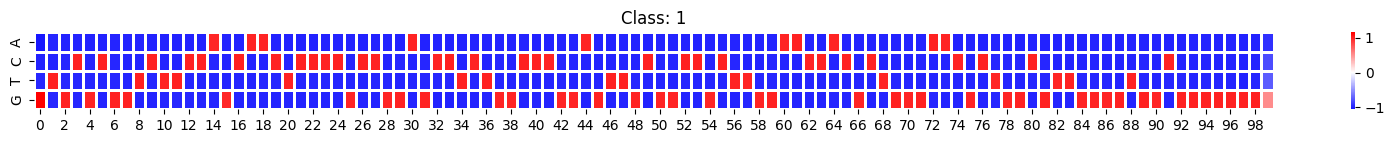

In [ ]:
model.eval()
sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
random_classes = sampled.to(device)
samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
n_print = 0
for image, class_show in zip(samples[-1], random_classes):
    if n_print < 4:
        plt.rcParams["figure.figsize"] = (20, 1)
        pd_seq = pd.DataFrame(image.reshape(4, 100))
        pd_seq.index = NUCLEOTIDES
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        plt.title(f'Class: {class_show}')
        plt.show()
        plt.rcParams["figure.figsize"] = (2, 2)
        n_print = n_print + 1

In [ ]:
n = 94
synt_df = sampling_reverse_encoding(n)

  0%|          | 0/94 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
un_bed_dataset = pd.read_csv('/content/curax_seq_filter_norm_to_500.bed', sep='\t', comment='t', header=None)
un_bed_dataset.columns = ['chrom', 'chromStart', 'chromEnd']

In [ ]:
fasta_file_path = "/content/synthetic_seqs.fasta"
with open(fasta_file_path, 'r') as fasta_file:
    fasta_lines = fasta_file.readlines()
fasta_lines = fasta_lines[:-8]
for i, line in enumerate(fasta_lines):
    if line.startswith('>seq_test_'):
        chrom_index = i % len(un_bed_dataset.chrom)
        chromosome_name = un_bed_dataset.chrom[chrom_index]
        fasta_lines[i] = f'> {chromosome_name}\n'

updated_fasta_file_path = 'curax_diff.fasta'
with open(updated_fasta_file_path, 'w') as updated_fasta_file:
    updated_fasta_file.writelines(fasta_lines)